In [109]:
import numpy as np
import pandas as pd
import os
import pickle
import gc

# 分布確認に使う
#import pandas_profiling as pdp
# 可視化
import matplotlib.pyplot as plt
# 前処理、特徴量作成 - sklearnを使う
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
# モデリング・精度と評価指標
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
#LGBM
import lightgbm as lgb

# NOTE matplotでの日本語文字化けを解消
#pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline

In [110]:
import pandas as pd
pd.options.display

train = pd.read_csv("train.csv", index_col=0) # 学習用データ
test = pd.read_csv("test.csv", index_col=0) # 学習用データ   # 評価用データ
sample_submit = pd.read_csv("sample_submission.csv", index_col=0, header=None) # 応募用サンプルファイル

In [111]:
train.head()

print("データ形状：")
print(train.shape)

print("データ数：")
print(len(train))

print("データのコラム数")
print(len(train.columns))

print("データ型一覧")
train.info()

データ形状：
(19984, 21)
データ数：
19984
データのコラム数
21
データ型一覧
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19984 entries, 0 to 19983
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  19984 non-null  object
 1   tree_dbh    19984 non-null  int64 
 2   curb_loc    19984 non-null  object
 3   health      19984 non-null  int64 
 4   steward     5101 non-null   object
 5   guards      5041 non-null   object
 6   sidewalk    19984 non-null  object
 7   user_type   19984 non-null  object
 8   problems    7741 non-null   object
 9   spc_common  19984 non-null  object
 10  spc_latin   19984 non-null  object
 11  nta         19984 non-null  object
 12  nta_name    19984 non-null  object
 13  borocode    19984 non-null  int64 
 14  boro_ct     19984 non-null  int64 
 15  boroname    19984 non-null  object
 16  zip_city    19984 non-null  object
 17  cb_num      19984 non-null  int64 
 18  st_senate   19984 non-null  int64 
 

In [112]:
train.head(10)

,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,...,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist
0,2015-06-29,14,OnCurb,1,NaN,NaN,Damage,Volunteer,NaN,English oak,...,QN45,Douglas Manor-Douglaston-Little Neck,4,4152901,Queens,Little Neck,411,11,25,23
1,2016-09-21,5,OnCurb,1,3or4,Helpful,NoDamage,Volunteer,NaN,crimson king maple,...,BX05,Bedford Park-Fordham North,2,2039901,Bronx,Bronx,207,33,78,15
2,2015-09-13,26,OnCurb,2,NaN,NaN,NoDamage,Volunteer,StonesBranchLights,English oak,...,SI01,Annadale-Huguenot-Prince's Bay-Eltingville,5,5017011,Staten Island,Staten Island,503,24,62,51
3,2016-05-09,15,OnCurb,0,NaN,NaN,Damage,NYC Parks Staff,NaN,honeylocust,...,SI11,Charleston-Richmond Valley-Tottenville,5,5024401,Staten Island,Staten Island,503,24,62,51
4,2016-06-24,23,OnCurb,1,NaN,NaN,NoDamage,Volunteer,Stones,London planetree,...,MN03,Central Harlem North-Polo Grounds,1,1022102,Manhattan,New York,110,30,70,9
5,2015-08-11,12,OnCurb,1,NaN,NaN,Damage,Volunteer,NaN,Amur cork tree,...,QN22,Flushing,4,4088901,Queens,Flushing,407,11,40,20
6,2015-10-24,8,OnCurb,1,NaN,Helpful,Damage,Volunteer,BranchLights,littleleaf linden,...,QN22,Flushing,4,4086500,Queens,Flushing,407,16,40,20
7,2016-06-04,6,OnCurb,0,NaN,NaN,NoDamage,NYC Parks Staff,NaN,cherry,...,QN08,St. Albans,4,4052400,Queens,Saint Albans,412,14,33,27
8,2016-07-22,18,OnCurb,1,NaN,NaN,Damage,TreesCount Staff,NaN,Siberian elm,...,BK82,East New York,3,3116600,Brooklyn,Brooklyn,305,18,54,37
9,2015-10-13,20,OnCurb,1,NaN,NaN,NoDamage,Volunteer,Stones,London planetree,...,QN52,East Flushing,4,4120300,Queens,Flushing,407,16,25,20


コラム数は全部で20個。ダミー化できるものはダミー化、そうでないものは分布数の多いもののみを取り出すなどの工夫をして
ドメイン知識を使った特徴量エンジニアリングをする。

In [113]:
print("データ型一覧")
train.info()

データ型一覧
<class 'pandas.core.frame.DataFrame'>
Int64Index: 19984 entries, 0 to 19983
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  19984 non-null  object
 1   tree_dbh    19984 non-null  int64 
 2   curb_loc    19984 non-null  object
 3   health      19984 non-null  int64 
 4   steward     5101 non-null   object
 5   guards      5041 non-null   object
 6   sidewalk    19984 non-null  object
 7   user_type   19984 non-null  object
 8   problems    7741 non-null   object
 9   spc_common  19984 non-null  object
 10  spc_latin   19984 non-null  object
 11  nta         19984 non-null  object
 12  nta_name    19984 non-null  object
 13  borocode    19984 non-null  int64 
 14  boro_ct     19984 non-null  int64 
 15  boroname    19984 non-null  object
 16  zip_city    19984 non-null  object
 17  cb_num      19984 non-null  int64 
 18  st_senate   19984 non-null  int64 
 19  st_assem    19984 non-null  int64 
 20 

tree_dbh, health, borocode, boro_ct, cb_num, st_senate, st_assem, cncldistで
ベースラインを作成する。その他本来ならint型にするべき値もベースラインに用いる

tree_dbh - 木の円周。量的変数
health - 木の健康状態、目的変数
borocode - ニューヨークの行政区分。質的変数
boro_ct - ニューヨーク市の行政区分（ボロー）の名称。質的変数
cb_num - コミュニティボード番号。質的変数
st_senate - 州上院地区番号。質的変数
st_assem - 州議会地区番号。質的変数
cncldist - 市議会の地区番号。質的変数

→使えるのはtree_dbhだけ。
次はstr・object型からint・float型に変換するべきものを探す

steward → 木の管理者数 
stewardはダミー化する。

tree_dbh,stewardの他にもまずは簡単にダミー化できる変数5つを使ってベースを作成する

In [114]:
print("データのコラム数")
print(train.columns)

データのコラム数
Index(['created_at', 'tree_dbh', 'curb_loc', 'health', 'steward', 'guards',
       'sidewalk', 'user_type', 'problems', 'spc_common', 'spc_latin', 'nta',
       'nta_name', 'borocode', 'boro_ct', 'boroname', 'zip_city', 'cb_num',
       'st_senate', 'st_assem', 'cncldist'],
      dtype='object')


In [115]:
print("データのコラム数")
print(test.columns)

データのコラム数
Index(['created_at', 'tree_dbh', 'curb_loc', 'steward', 'guards', 'sidewalk',
       'user_type', 'problems', 'spc_common', 'spc_latin', 'nta', 'nta_name',
       'borocode', 'boro_ct', 'boroname', 'zip_city', 'cb_num', 'st_senate',
       'st_assem', 'cncldist'],
      dtype='object')


In [116]:
#目的変数の分布を確認
counts = train["health"].value_counts()
counts

1    15751
0     3535
2      698
Name: health, dtype: int64

In [117]:
counts = counts.sort_index()

<Axes: >

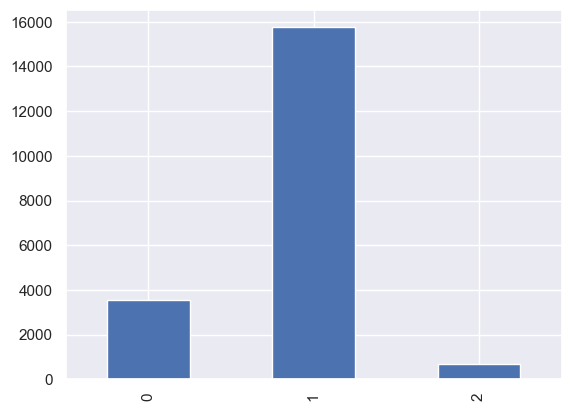

In [118]:
counts.plot.bar("health")

目的変数は1(good)であることが殆どだが、0や2(normal, bad)が約20%。

OnCurb            18777
OffsetFromCurb     1207
Name: curb_loc, dtype: int64


<Axes: >

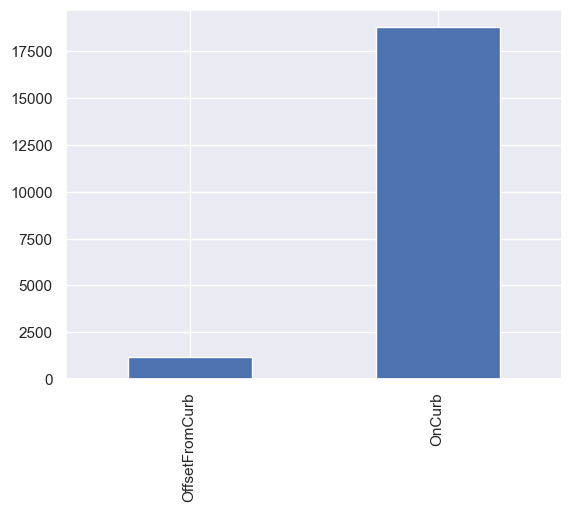

In [119]:
#目的変数の分布を確認
counts = train["curb_loc"].value_counts()
print(counts)
counts = counts.sort_index()
counts.plot.bar("curb_loc")

1or2       3999
3or4       1079
4orMore      23
Name: steward, dtype: int64


<Axes: >

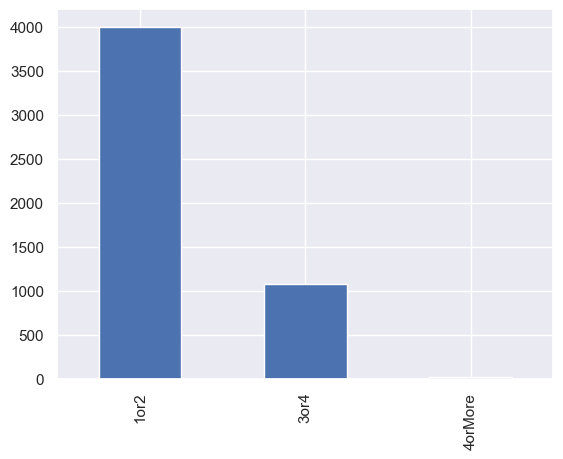

In [120]:
#目的変数の分布を確認
counts = train["steward"].value_counts()
print(counts)
counts = counts.sort_index()
counts.plot.bar("steward")

Helpful    3650
Unsure      737
Harmful     654
Name: guards, dtype: int64


<Axes: >

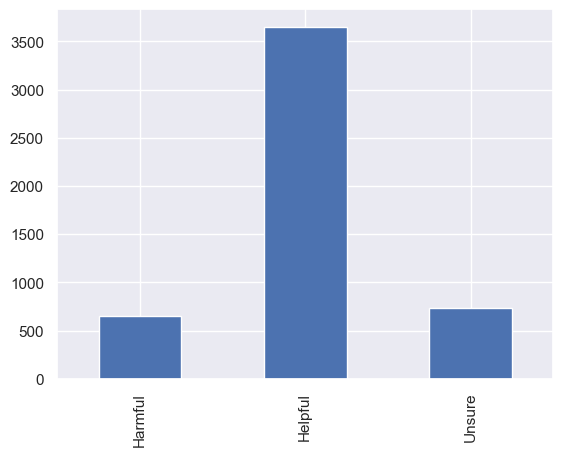

In [121]:
#目的変数の分布を確認
counts = train["guards"].value_counts()
print(counts)

counts = counts.sort_index()
counts.plot.bar("guards")

NoDamage    10689
Damage       9295
Name: sidewalk, dtype: int64


<Axes: >

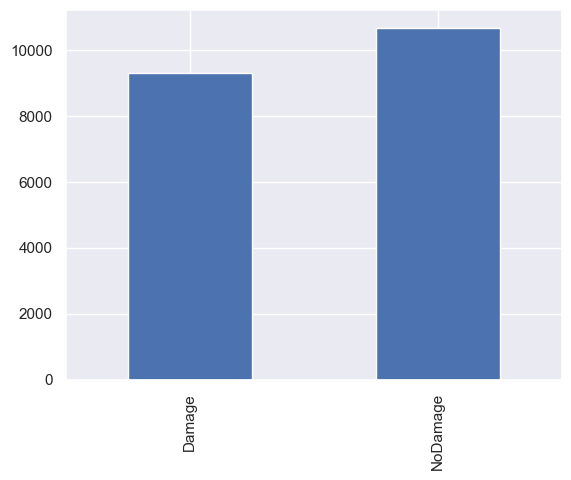

In [122]:
#目的変数の分布を確認
counts = train["sidewalk"].value_counts()
print(counts)

counts = counts.sort_index()
counts.plot.bar("sidewalk")

Volunteer           11189
TreesCount Staff     5795
NYC Parks Staff      3000
Name: user_type, dtype: int64


<Axes: >

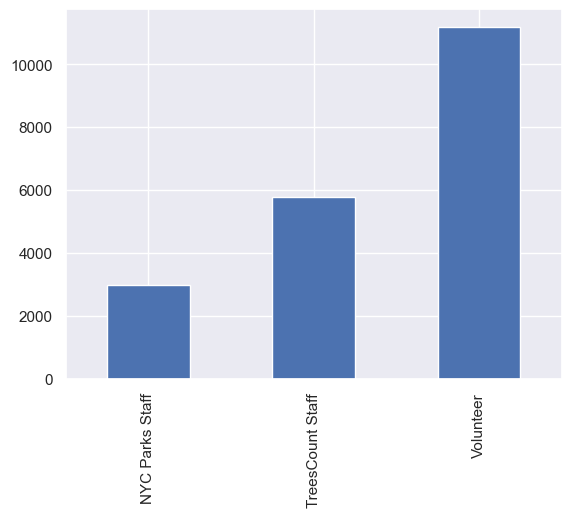

In [123]:
#目的変数の分布を確認
counts = train["user_type"].value_counts()
print(counts)

counts = counts.sort_index()
counts.plot.bar("user_type")

<Axes: >

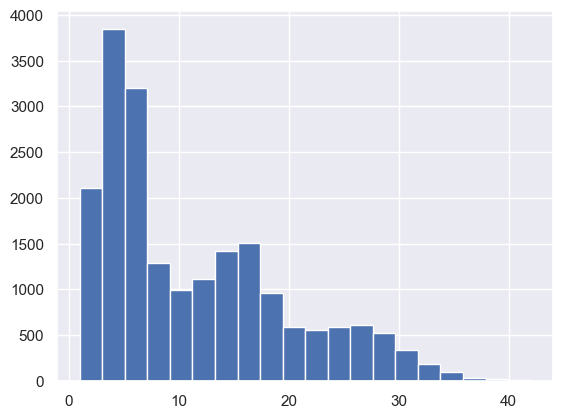

In [124]:
train["tree_dbh"].hist(bins=20)

→ ポアソン分布に近い。指数化すればより有効な値になるかも？

Stones                                  2219
BranchLights                            1036
StonesBranchLights                       762
BranchOther                              408
RootOther                                333
                                        ... 
StonesRootOtherTrunkOtherBranchOther       8
StonesRootOtherWiresRopeBranchOther        5
StonesMetalGratesTrunkOther                4
TrunkLightsBranchLightsBranchOther         4
WiresRopeTrunkLightsBranchLights           4
Name: problems, Length: 73, dtype: int64


<Axes: >

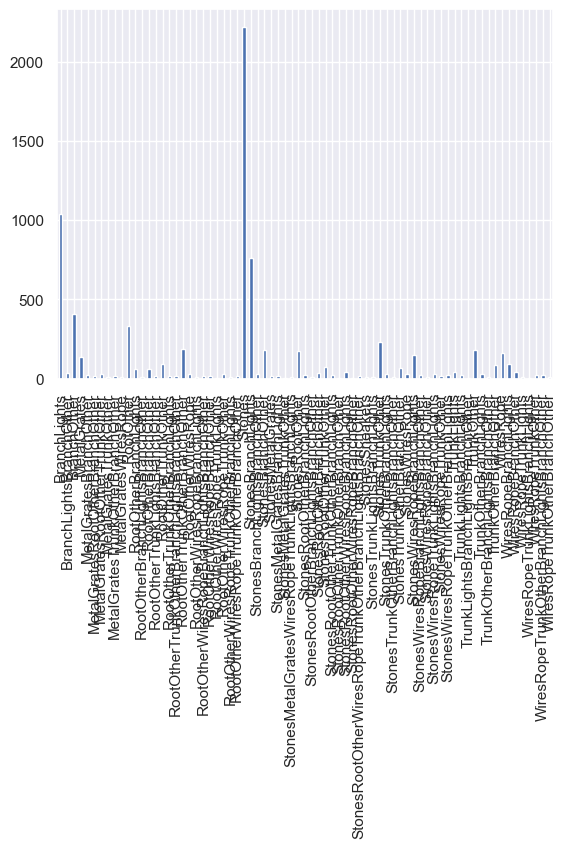

In [125]:
#目的変数の分布を確認
counts = train["problems"].value_counts()
print(counts)

counts = counts.sort_index()
counts.plot.bar("problems")

In [126]:
#目的変数の分布を確認
prob_counts = train["problems"].value_counts()
print(prob_counts)

#counts = counts.sort_index()
prob_counts[:10]

Stones                                  2219
BranchLights                            1036
StonesBranchLights                       762
BranchOther                              408
RootOther                                333
                                        ... 
StonesRootOtherTrunkOtherBranchOther       8
StonesRootOtherWiresRopeBranchOther        5
StonesMetalGratesTrunkOther                4
TrunkLightsBranchLightsBranchOther         4
WiresRopeTrunkLightsBranchLights           4
Name: problems, Length: 73, dtype: int64


Stones                            2219
BranchLights                      1036
StonesBranchLights                 762
BranchOther                        408
RootOther                          333
StonesTrunkOther                   230
RootOtherTrunkOtherBranchOther     190
TrunkOther                         183
StonesBranchOther                  180
StonesRootOther                    173
Name: problems, dtype: int64

London planetree       2237
pin oak                2140
cherry                 1689
Japanese zelkova       1470
littleleaf linden      1303
                       ... 
Chinese chestnut          3
pignut hickory            3
Kentucky yellowwood       2
pond cypress              1
Himalayan cedar           1
Name: spc_common, Length: 120, dtype: int64


<Axes: >

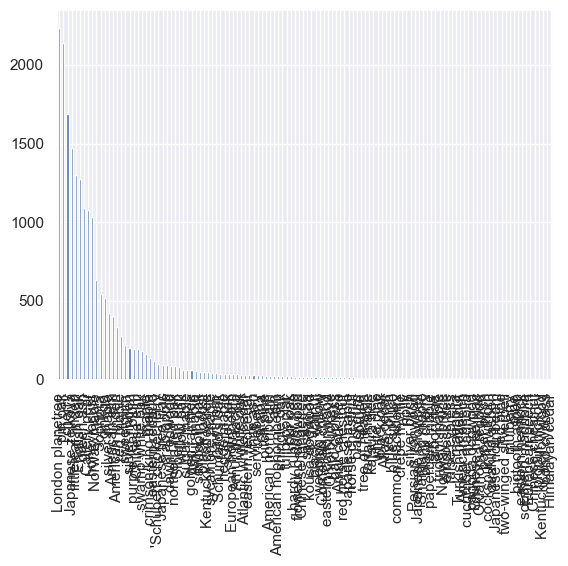

In [127]:
spc_counts = train["spc_common"].value_counts()
print(spc_counts)

#counts = counts.sort_index()
spc_counts.plot.bar("spc_common")

In [128]:
# 木の種類 - 最初の10をダミー化する
counts[:15].sum()

2216

Platanus x acerifolia    2237
Quercus palustris        2140
Prunus                   1689
Zelkova serrata          1470
Tilia cordata            1303
                         ... 
Castanea mollissima         3
Carya glabra                3
Cladrastis kentukea         2
Taxodium ascendens          1
Cedrus deodara              1
Name: spc_latin, Length: 120, dtype: int64


<Axes: >

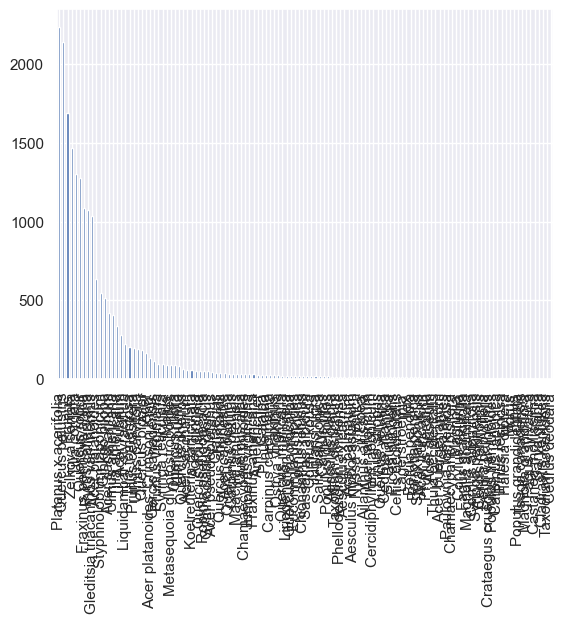

In [129]:
counts = train["spc_latin"].value_counts()
print(counts)

#counts = counts.sort_index()
counts.plot.bar("spc_latin")

In [130]:
# 木の種類 - 最初の10をダミー化する
counts[:10]

Platanus x acerifolia                 2237
Quercus palustris                     2140
Prunus                                1689
Zelkova serrata                       1470
Tilia cordata                         1303
Quercus robur                         1277
Fraxinus pennsylvanica                1089
Pyrus calleryana                      1076
Gleditsia triacanthos var. inermis    1034
Acer platanoides                       634
Name: spc_latin, dtype: int64

SI54    368
SI11    359
BK82    326
BK45    306
SI32    306
       ... 
MN17      6
MN21      5
QN68      4
BK27      2
MN20      1
Name: nta, Length: 187, dtype: int64


<Axes: >

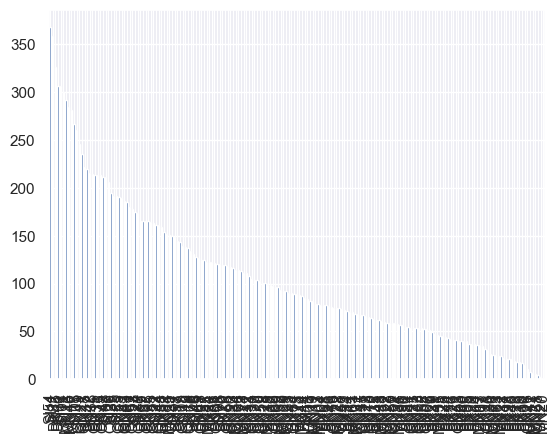

In [131]:
#地域（Neighborhood Tabulation Area）の略称
counts = train["nta"].value_counts()
print(counts)

#counts = counts.sort_index()
counts.plot.bar("nta")

Great Kills                                       368
Charleston-Richmond Valley-Tottenville            359
East New York                                     326
Georgetown-Marine Park-Bergen Beach-Mill Basin    306
Rossville-Woodrow                                 306
                                                 ... 
Midtown-Midtown South                               6
Gramercy                                            5
Queensbridge-Ravenswood-Long Island City            4
Bath Beach                                          2
Murray Hill-Kips Bay                                1
Name: nta_name, Length: 187, dtype: int64


<Axes: >

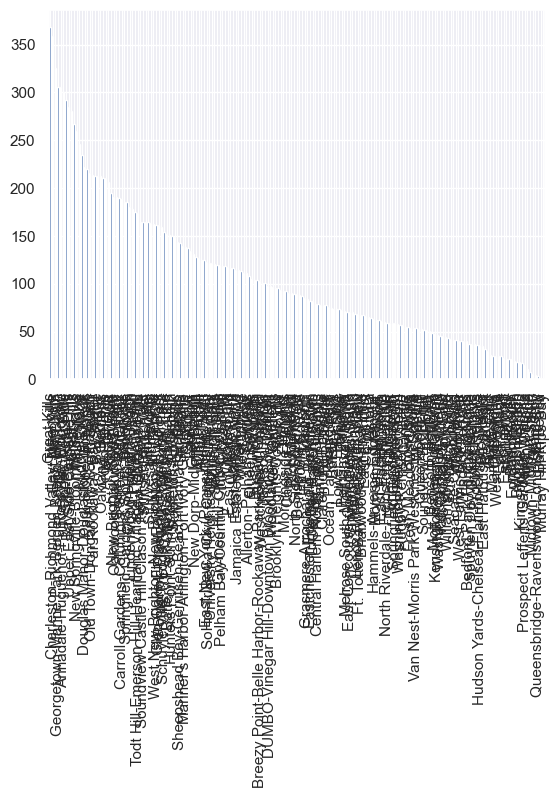

In [132]:
#地域（Neighborhood Tabulation Area）の略称
counts = train["nta_name"].value_counts()
print(counts)

#counts = counts.sort_index()
counts.plot.bar("nta_name")

In [133]:
# vill, beach, side, hill, park, water, bay, gardenなど木に影響しそうな名称を抽出するか？？
counts[:30]

Great Kills                                       368
Charleston-Richmond Valley-Tottenville            359
East New York                                     326
Georgetown-Marine Park-Bergen Beach-Mill Basin    306
Rossville-Woodrow                                 306
Annadale-Huguenot-Prince's Bay-Eltingville        300
Upper West Side                                   292
Bayside-Bayside Hills                             285
Upper East Side-Carnegie Hill                     281
Forest Hills                                      267
New Springville-Bloomfield-Travis                 260
Whitestone                                        246
Middle Village                                    235
Douglas Manor-Douglaston-Little Neck              222
Park Slope-Gowanus                                220
Flatbush                                          216
Old Town-Dongan Hills-South Beach                 214
Far Rockaway-Bayswater                            213
Bay Ridge                   

4    6572
3    5119
5    3735
1    2288
2    2270
Name: borocode, dtype: int64


<Axes: >

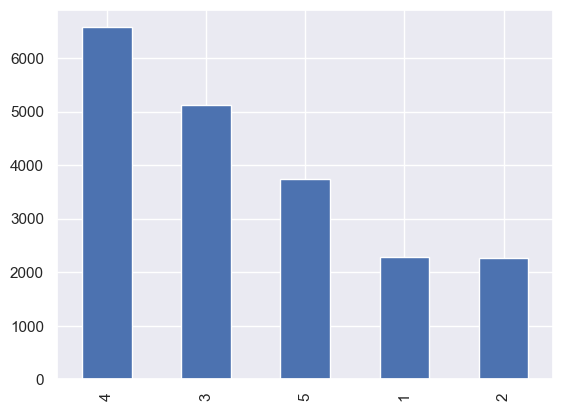

In [134]:
#ニューヨーク市の行政区分（ボロー）のコード
#ボロコードは非常に有益そう。量的変数にする
counts = train["borocode"].value_counts()
print(counts)

#counts = counts.sort_index()
counts.plot.bar("borocode")

5022600    204
1031704    149
5020804    126
5005900    112
5020801    103
          ... 
4026300      1
2041800      1
2011900      1
3039100      1
3066200      1
Name: boro_ct, Length: 1193, dtype: int64


<Axes: >

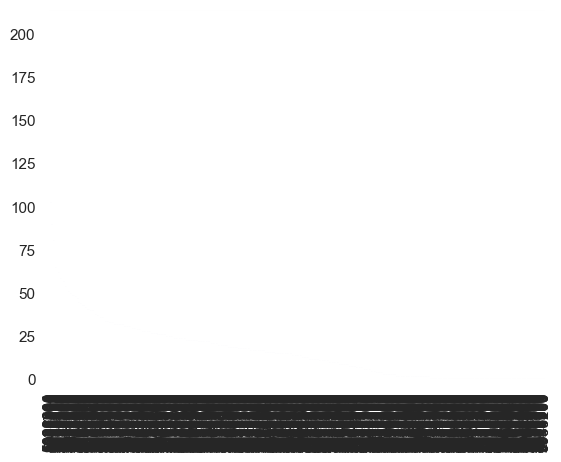

In [135]:
counts = train["boro_ct"].value_counts()
print(counts)

#counts = counts.sort_index()
counts.plot.bar("boro_ct")

Queens           6572
Brooklyn         5119
Staten Island    3735
Manhattan        2288
Bronx            2270
Name: boroname, dtype: int64


<Axes: >

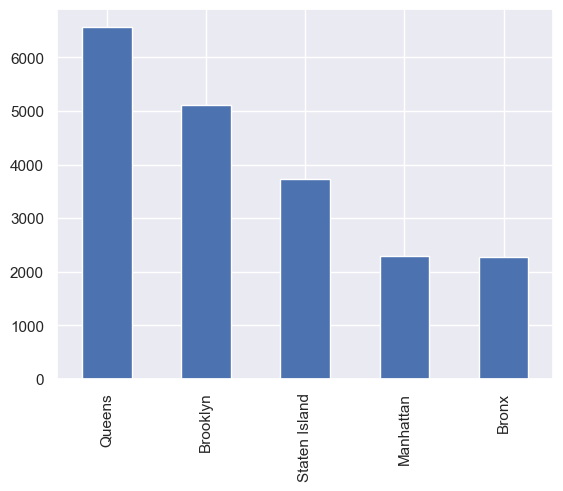

In [136]:
#　ニューヨーク市の行政区分（ボロー）の名称
#　ボロー名称は有効そう。ダミー変数にする

counts = train["boroname"].value_counts()
print(counts)

#counts = counts.sort_index()
counts.plot.bar("boroname")

Brooklyn               5119
Staten Island          3735
Bronx                  2270
New York               2267
Jamaica                 660
Flushing                615
Ridgewood               331
Oakland Gardens         281
Whitestone              252
Springfield Gardens     248
Forest Hills            248
Far Rockaway            241
Fresh Meadows           226
Little Neck             222
Bayside                 218
Middle Village          213
Rosedale                186
Howard Beach            178
Queens Village          173
Astoria                 161
South Ozone Park        145
East Elmhurst           143
Bellerose               141
College Point           135
Maspeth                 129
Ozone Park              129
Glen Oaks               128
Long Island City        114
Woodside                108
Richmond Hill           104
Elmhurst                104
Cambria Heights          91
Rockaway Park            84
Kew Gardens              68
Saint Albans             68
Hollis              

<Axes: >

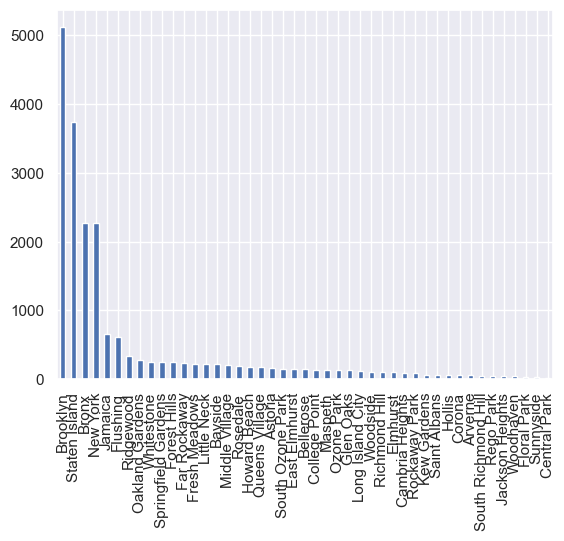

In [137]:
#　郵便番号に関連する都市または地区
#　最初の5-10個をダミー化するか??
# 頻度を量的変数にする、などより有効なダミー化も検討中

counts = train["zip_city"].value_counts()
print(counts)

#counts = counts.sort_index()
counts.plot.bar("zip_city")

503    1735
501    1140
413    1026
502     860
411     843
407     778
405     672
305     620
408     560
412     517
318     505
301     503
410     486
108     442
107     435
306     414
303     397
302     379
414     379
209     358
210     353
315     338
314     303
406     296
212     271
307     263
312     257
101     252
211     250
310     250
402     229
409     225
401     214
111     184
403     175
316     174
404     172
112     170
103     156
110     149
205     148
208     141
311     140
206     140
109     139
317     136
202     135
104     134
102     133
308     133
204     129
203     128
201     128
309     119
304     117
207      89
106      87
313      71
105       7
Name: cb_num, dtype: int64


<Axes: >

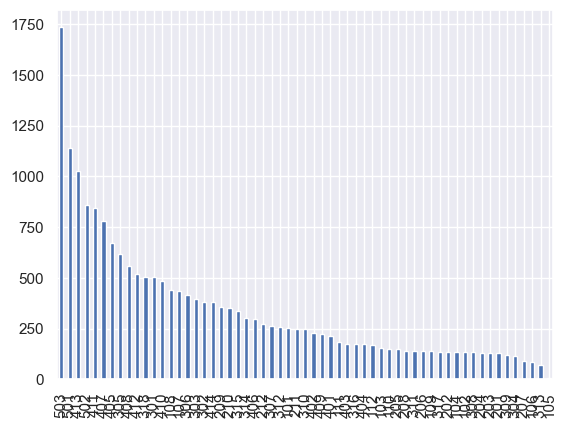

In [138]:
#　ニューヨーク市の行政区分（ボロー）の名称
#　ボロー名称は有効そう。ダミー変数にする

counts = train["cb_num"].value_counts()
print(counts)

#counts = counts.sort_index()
counts.plot.bar("cb_num")

24    2905
11    1885
15    1503
23    1035
10    1028
34     965
25     963
14     830
19     771
26     750
22     711
18     632
21     560
16     550
28     508
32     480
30     478
17     466
20     417
29     400
13     399
31     388
27     380
12     377
33     308
36     295
Name: st_senate, dtype: int64


<Axes: >

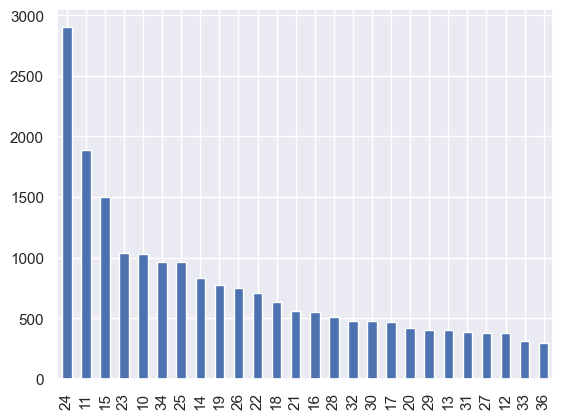

In [139]:
#　ニューヨーク市の行政区分（ボロー）の名称
#　ボロー名称は有効そう。ダミー変数にする

counts = train["st_senate"].value_counts()
print(counts)

#counts = counts.sort_index()
counts.plot.bar("st_senate")

62    1459
64     827
63     789
61     783
26     696
      ... 
47     107
74      92
72      89
78      88
49      54
Name: st_assem, Length: 65, dtype: int64


<Axes: >

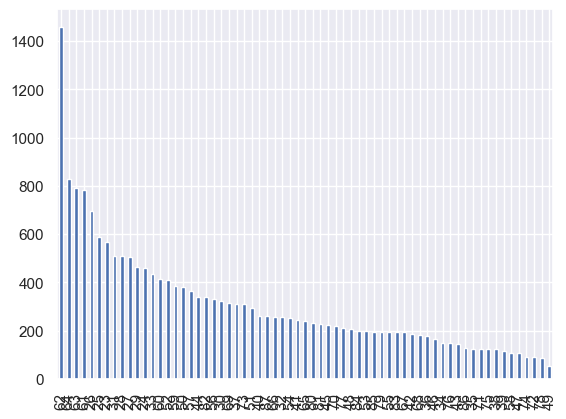

In [140]:
#　ニューヨーク市の行政区分（ボロー）の名称
#　ボロー名称は有効そう。ダミー変数にする

counts = train["st_assem"].value_counts()
print(counts)

#counts = counts.sort_index()
counts.plot.bar("st_assem")

51    1604
50    1093
49    1038
19     889
23     849
31     788
30     660
24     539
32     538
33     529
13     485
46     449
39     429
35     413
29     413
42     396
27     393
4      382
36     371
28     365
6      355
37     347
18     337
17     334
20     326
1      320
43     282
48     278
9      270
38     269
41     267
3      265
34     264
44     256
11     249
12     245
45     239
47     233
7      229
26     214
15     207
22     194
25     181
8      177
14     175
21     169
16     163
40     151
10     140
5      127
2       98
Name: cncldist, dtype: int64


<Axes: >

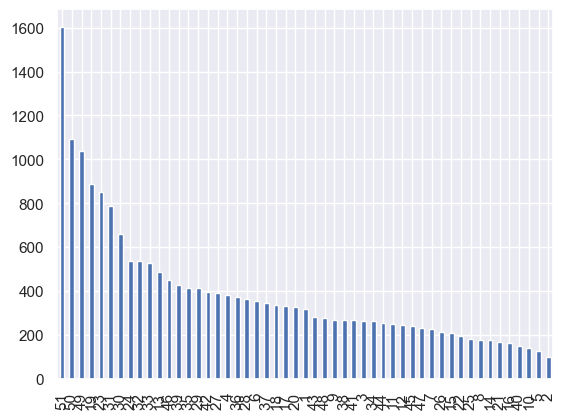

In [141]:
#　ニューヨーク市の行政区分（ボロー）の名称
#　ボロー名称は有効そう。ダミー変数にする

counts = train["cncldist"].value_counts()
print(counts)

#counts = counts.sort_index()
counts.plot.bar("cncldist")

In [142]:
len(counts)

51

# 前処理

# ベースライン作成に用いる変数
tree_dbh
curb_loc
steward
guards
sidewalk
user_type

In [143]:
x_list = ["tree_dbh","curb_loc","steward","guards","sidewalk","user_type","problems","spc_common","nta","borocode","boro_ct", "zip_city", "cb_num", "st_senate", "st_assem", "cncldist"]
y_list = ["health"]
dummy_list = ["curb_loc","steward","guards","sidewalk","user_type","borocode"]

In [144]:
train.head(5)

,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,...,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist
0,2015-06-29,14,OnCurb,1,NaN,NaN,Damage,Volunteer,NaN,English oak,...,QN45,Douglas Manor-Douglaston-Little Neck,4,4152901,Queens,Little Neck,411,11,25,23
1,2016-09-21,5,OnCurb,1,3or4,Helpful,NoDamage,Volunteer,NaN,crimson king maple,...,BX05,Bedford Park-Fordham North,2,2039901,Bronx,Bronx,207,33,78,15
2,2015-09-13,26,OnCurb,2,NaN,NaN,NoDamage,Volunteer,StonesBranchLights,English oak,...,SI01,Annadale-Huguenot-Prince's Bay-Eltingville,5,5017011,Staten Island,Staten Island,503,24,62,51
3,2016-05-09,15,OnCurb,0,NaN,NaN,Damage,NYC Parks Staff,NaN,honeylocust,...,SI11,Charleston-Richmond Valley-Tottenville,5,5024401,Staten Island,Staten Island,503,24,62,51
4,2016-06-24,23,OnCurb,1,NaN,NaN,NoDamage,Volunteer,Stones,London planetree,...,MN03,Central Harlem North-Polo Grounds,1,1022102,Manhattan,New York,110,30,70,9


In [145]:
train.head(5)

,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,...,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist
0,2015-06-29,14,OnCurb,1,NaN,NaN,Damage,Volunteer,NaN,English oak,...,QN45,Douglas Manor-Douglaston-Little Neck,4,4152901,Queens,Little Neck,411,11,25,23
1,2016-09-21,5,OnCurb,1,3or4,Helpful,NoDamage,Volunteer,NaN,crimson king maple,...,BX05,Bedford Park-Fordham North,2,2039901,Bronx,Bronx,207,33,78,15
2,2015-09-13,26,OnCurb,2,NaN,NaN,NoDamage,Volunteer,StonesBranchLights,English oak,...,SI01,Annadale-Huguenot-Prince's Bay-Eltingville,5,5017011,Staten Island,Staten Island,503,24,62,51
3,2016-05-09,15,OnCurb,0,NaN,NaN,Damage,NYC Parks Staff,NaN,honeylocust,...,SI11,Charleston-Richmond Valley-Tottenville,5,5024401,Staten Island,Staten Island,503,24,62,51
4,2016-06-24,23,OnCurb,1,NaN,NaN,NoDamage,Volunteer,Stones,London planetree,...,MN03,Central Harlem North-Polo Grounds,1,1022102,Manhattan,New York,110,30,70,9


## 木の健康状態（目的変数）
0:Fair（普通） 1:Good（良い） 2:Poor（悪い）
0:良い、1:普通、2:悪い、という値に置き換える

In [146]:
train['health'] = train['health'].map({0:1, 1:0, 2:2})
train

,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,...,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist
0,2015-06-29,14,OnCurb,0,NaN,NaN,Damage,Volunteer,NaN,English oak,...,QN45,Douglas Manor-Douglaston-Little Neck,4,4152901,Queens,Little Neck,411,11,25,23
1,2016-09-21,5,OnCurb,0,3or4,Helpful,NoDamage,Volunteer,NaN,crimson king maple,...,BX05,Bedford Park-Fordham North,2,2039901,Bronx,Bronx,207,33,78,15
2,2015-09-13,26,OnCurb,2,NaN,NaN,NoDamage,Volunteer,StonesBranchLights,English oak,...,SI01,Annadale-Huguenot-Prince's Bay-Eltingville,5,5017011,Staten Island,Staten Island,503,24,62,51
3,2016-05-09,15,OnCurb,1,NaN,NaN,Damage,NYC Parks Staff,NaN,honeylocust,...,SI11,Charleston-Richmond Valley-Tottenville,5,5024401,Staten Island,Staten Island,503,24,62,51
4,2016-06-24,23,OnCurb,0,NaN,NaN,NoDamage,Volunteer,Stones,London planetree,...,MN03,Central Harlem North-Polo Grounds,1,1022102,Manhattan,New York,110,30,70,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19979,2016-07-15,19,OnCurb,2,NaN,NaN,Damage,Volunteer,NaN,shingle oak,...,SI24,Todt Hill-Emerson Hill-Heartland Village-Light...,5,5018100,Staten Island,Staten Island,502,24,62,50
19980,2016-07-08,5,OnCurb,0,NaN,NaN,NoDamage,NYC Parks Staff,NaN,catalpa,...,SI32,Rossville-Woodrow,5,5020804,Staten Island,Staten Island,503,24,62,51
19981,2015-08-20,21,OnCurb,1,NaN,NaN,Damage,Volunteer,NaN,English oak,...,SI48,Arden Heights,5,5017010,Staten Island,Staten Island,503,24,62,51
19982,2016-06-20,4,OnCurb,0,1or2,NaN,NoDamage,NYC Parks Staff,NaN,littleleaf linden,...,MN25,Battery Park City-Lower Manhattan,1,1031704,Manhattan,New York,101,26,65,1


In [147]:
#　説明変数+目的変数とバリデーション設計
X_train, y_train = train[x_list], train[y_list]
X_train

,tree_dbh,curb_loc,steward,guards,sidewalk,user_type,problems,spc_common,nta,borocode,boro_ct,zip_city,cb_num,st_senate,st_assem,cncldist
0,14,OnCurb,NaN,NaN,Damage,Volunteer,NaN,English oak,QN45,4,4152901,Little Neck,411,11,25,23
1,5,OnCurb,3or4,Helpful,NoDamage,Volunteer,NaN,crimson king maple,BX05,2,2039901,Bronx,207,33,78,15
2,26,OnCurb,NaN,NaN,NoDamage,Volunteer,StonesBranchLights,English oak,SI01,5,5017011,Staten Island,503,24,62,51
3,15,OnCurb,NaN,NaN,Damage,NYC Parks Staff,NaN,honeylocust,SI11,5,5024401,Staten Island,503,24,62,51
4,23,OnCurb,NaN,NaN,NoDamage,Volunteer,Stones,London planetree,MN03,1,1022102,New York,110,30,70,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19979,19,OnCurb,NaN,NaN,Damage,Volunteer,NaN,shingle oak,SI24,5,5018100,Staten Island,502,24,62,50
19980,5,OnCurb,NaN,NaN,NoDamage,NYC Parks Staff,NaN,catalpa,SI32,5,5020804,Staten Island,503,24,62,51
19981,21,OnCurb,NaN,NaN,Damage,Volunteer,NaN,English oak,SI48,5,5017010,Staten Island,503,24,62,51
19982,4,OnCurb,1or2,NaN,NoDamage,NYC Parks Staff,NaN,littleleaf linden,MN25,1,1031704,New York,101,26,65,1


In [148]:
y_train

,health
0,0
1,0
2,2
3,1
4,0
...,...
19979,2
19980,0
19981,1
19982,0


In [149]:
X_train.isnull().sum()

tree_dbh          0
curb_loc          0
steward       14883
guards        14943
sidewalk          0
user_type         0
problems      12243
spc_common        0
nta               0
borocode          0
boro_ct           0
zip_city          0
cb_num            0
st_senate         0
st_assem          0
cncldist          0
dtype: int64

→　欠損値は'NULL'というカテゴリに置き換え、欠損であるという情報=質的変数の1つとして処理する

In [150]:
train.fillna('NULL', inplace=True)

In [151]:
column_means = train.groupby("steward")["health"].mean("health")
column_means

steward
1or2      0.22
3or4      0.30
4orMore   0.48
NULL      0.25
Name: health, dtype: float64

In [152]:
test["steward"]

19984     NaN
19985    1or2
19986     NaN
19987     NaN
19988    1or2
         ... 
39964    1or2
39965    1or2
39966     NaN
39967     NaN
39968     NaN
Name: steward, Length: 19702, dtype: object

In [153]:
X_train.fillna('NULL', inplace=True)

In [154]:
X_train.head(10)

,tree_dbh,curb_loc,steward,guards,sidewalk,user_type,problems,spc_common,nta,borocode,boro_ct,zip_city,cb_num,st_senate,st_assem,cncldist
0,14,OnCurb,NULL,NULL,Damage,Volunteer,NULL,English oak,QN45,4,4152901,Little Neck,411,11,25,23
1,5,OnCurb,3or4,Helpful,NoDamage,Volunteer,NULL,crimson king maple,BX05,2,2039901,Bronx,207,33,78,15
2,26,OnCurb,NULL,NULL,NoDamage,Volunteer,StonesBranchLights,English oak,SI01,5,5017011,Staten Island,503,24,62,51
3,15,OnCurb,NULL,NULL,Damage,NYC Parks Staff,NULL,honeylocust,SI11,5,5024401,Staten Island,503,24,62,51
4,23,OnCurb,NULL,NULL,NoDamage,Volunteer,Stones,London planetree,MN03,1,1022102,New York,110,30,70,9
5,12,OnCurb,NULL,NULL,Damage,Volunteer,NULL,Amur cork tree,QN22,4,4088901,Flushing,407,11,40,20
6,8,OnCurb,NULL,Helpful,Damage,Volunteer,BranchLights,littleleaf linden,QN22,4,4086500,Flushing,407,16,40,20
7,6,OnCurb,NULL,NULL,NoDamage,NYC Parks Staff,NULL,cherry,QN08,4,4052400,Saint Albans,412,14,33,27
8,18,OnCurb,NULL,NULL,Damage,TreesCount Staff,NULL,Siberian elm,BK82,3,3116600,Brooklyn,305,18,54,37
9,20,OnCurb,NULL,NULL,NoDamage,Volunteer,Stones,London planetree,QN52,4,4120300,Flushing,407,16,25,20


In [155]:
# problemsをbool変換 → 問題があるか否かのダミー変数にする
# train['bool_problems'] = train['problems'].apply(lambda x: 0 if x=='NULL' else 1)

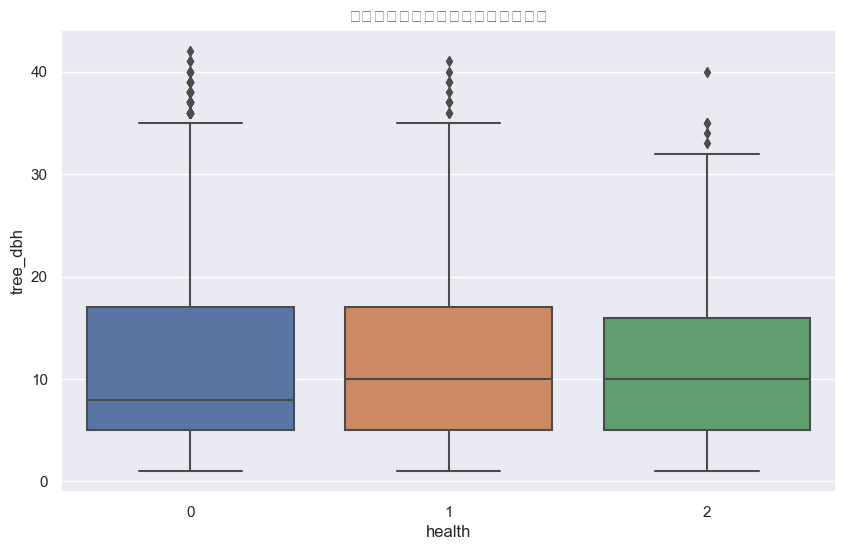

In [156]:
#　木の直径とhealthの関係
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

plt.figure(figsize=(10, 6))
sns.boxplot(x='health', y='tree_dbh', data=train)
plt.title('木の円周・木の健康状態の箱ひげ図')
plt.show()

→ badな木は若干円周が大きい。育ちすぎ等の原因があるかもしれない

# 特徴量エンジニアリング

今回の特徴量エンジニアリング

x_list = ["tree_dbh", "curb_loc","steward","guards","sidewalk","user_type"]
y_list = ["health"]
dummy_list = ["curb_loc","steward","guards","sidewalk","user_type"]

- ["curb_loc","steward","guards","sidewalk","user_type"]をダミー化する
- "problems"をダミー化する。その際最初の10行だけを残す


# 少数の質的変数をダミー化
["curb_loc","steward","guards","sidewalk","user_type","borocode"]

In [157]:
dummy_list = ["curb_loc","steward","guards","sidewalk","user_type","borocode"]

X_train = pd.get_dummies(X_train, columns = dummy_list, drop_first=False)
X_train

,tree_dbh,problems,spc_common,nta,boro_ct,zip_city,cb_num,st_senate,st_assem,cncldist,...,sidewalk_Damage,sidewalk_NoDamage,user_type_NYC Parks Staff,user_type_TreesCount Staff,user_type_Volunteer,borocode_1,borocode_2,borocode_3,borocode_4,borocode_5
0,14,NULL,English oak,QN45,4152901,Little Neck,411,11,25,23,...,1,0,0,0,1,0,0,0,1,0
1,5,NULL,crimson king maple,BX05,2039901,Bronx,207,33,78,15,...,0,1,0,0,1,0,1,0,0,0
2,26,StonesBranchLights,English oak,SI01,5017011,Staten Island,503,24,62,51,...,0,1,0,0,1,0,0,0,0,1
3,15,NULL,honeylocust,SI11,5024401,Staten Island,503,24,62,51,...,1,0,1,0,0,0,0,0,0,1
4,23,Stones,London planetree,MN03,1022102,New York,110,30,70,9,...,0,1,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19979,19,NULL,shingle oak,SI24,5018100,Staten Island,502,24,62,50,...,1,0,0,0,1,0,0,0,0,1
19980,5,NULL,catalpa,SI32,5020804,Staten Island,503,24,62,51,...,0,1,1,0,0,0,0,0,0,1
19981,21,NULL,English oak,SI48,5017010,Staten Island,503,24,62,51,...,1,0,0,0,1,0,0,0,0,1
19982,4,NULL,littleleaf linden,MN25,1031704,New York,101,26,65,1,...,0,1,1,0,0,1,0,0,0,0


# 質的変数をターゲットエンコーディング
まず各コラムの平均値を求める

In [158]:
# 一挙にターゲットエンコーディング
cols = ["curb_loc","steward","guards","sidewalk","user_type","problems","spc_common","nta","borocode","boro_ct", "zip_city", "cb_num", "st_senate", "st_assem", "cncldist"]
for col in cols:
    column_means = train.groupby(col)["health"].mean("health")
    column_means
    
    colname = col + "_tg_enc"
    
    X_train[colname] = train[col].map(column_means)

In [159]:
X_train

,tree_dbh,problems,spc_common,nta,boro_ct,zip_city,cb_num,st_senate,st_assem,cncldist,...,problems_tg_enc,spc_common_tg_enc,nta_tg_enc,borocode_tg_enc,boro_ct_tg_enc,zip_city_tg_enc,cb_num_tg_enc,st_senate_tg_enc,st_assem_tg_enc,cncldist_tg_enc
0,14,NULL,English oak,QN45,4152901,Little Neck,411,11,25,23,...,0.24,0.32,0.30,0.26,0.43,0.30,0.28,0.27,0.27,0.28
1,5,NULL,crimson king maple,BX05,2039901,Bronx,207,33,78,15,...,0.24,0.17,0.22,0.25,0.21,0.25,0.24,0.28,0.22,0.29
2,26,StonesBranchLights,English oak,SI01,5017011,Staten Island,503,24,62,51,...,0.29,0.32,0.27,0.25,0.33,0.25,0.24,0.25,0.25,0.25
3,15,NULL,honeylocust,SI11,5024401,Staten Island,503,24,62,51,...,0.24,0.26,0.25,0.25,0.26,0.25,0.24,0.25,0.25,0.25
4,23,Stones,London planetree,MN03,1022102,New York,110,30,70,9,...,0.25,0.23,0.29,0.24,0.29,0.24,0.24,0.22,0.21,0.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19979,19,NULL,shingle oak,SI24,5018100,Staten Island,502,24,62,50,...,0.24,0.38,0.33,0.25,0.44,0.25,0.26,0.25,0.25,0.26
19980,5,NULL,catalpa,SI32,5020804,Staten Island,503,24,62,51,...,0.24,0.04,0.24,0.25,0.29,0.25,0.24,0.25,0.25,0.25
19981,21,NULL,English oak,SI48,5017010,Staten Island,503,24,62,51,...,0.24,0.32,0.21,0.25,0.26,0.25,0.24,0.25,0.25,0.25
19982,4,NULL,littleleaf linden,MN25,1031704,New York,101,26,65,1,...,0.24,0.25,0.19,0.24,0.17,0.24,0.24,0.21,0.19,0.24


In [160]:
# problems, spc_commonをドロップアウト
drop_col = ["problems","spc_common","nta","boro_ct", "zip_city", "cb_num", "st_senate", "st_assem", "cncldist"]

X_train = X_train.drop(drop_col , axis=1)
X_train

,tree_dbh,curb_loc_OffsetFromCurb,curb_loc_OnCurb,steward_1or2,steward_3or4,steward_4orMore,steward_NULL,guards_Harmful,guards_Helpful,guards_NULL,...,problems_tg_enc,spc_common_tg_enc,nta_tg_enc,borocode_tg_enc,boro_ct_tg_enc,zip_city_tg_enc,cb_num_tg_enc,st_senate_tg_enc,st_assem_tg_enc,cncldist_tg_enc
0,14,0,1,0,0,0,1,0,0,1,...,0.24,0.32,0.30,0.26,0.43,0.30,0.28,0.27,0.27,0.28
1,5,0,1,0,1,0,0,0,1,0,...,0.24,0.17,0.22,0.25,0.21,0.25,0.24,0.28,0.22,0.29
2,26,0,1,0,0,0,1,0,0,1,...,0.29,0.32,0.27,0.25,0.33,0.25,0.24,0.25,0.25,0.25
3,15,0,1,0,0,0,1,0,0,1,...,0.24,0.26,0.25,0.25,0.26,0.25,0.24,0.25,0.25,0.25
4,23,0,1,0,0,0,1,0,0,1,...,0.25,0.23,0.29,0.24,0.29,0.24,0.24,0.22,0.21,0.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19979,19,0,1,0,0,0,1,0,0,1,...,0.24,0.38,0.33,0.25,0.44,0.25,0.26,0.25,0.25,0.26
19980,5,0,1,0,0,0,1,0,0,1,...,0.24,0.04,0.24,0.25,0.29,0.25,0.24,0.25,0.25,0.25
19981,21,0,1,0,0,0,1,0,0,1,...,0.24,0.32,0.21,0.25,0.26,0.25,0.24,0.25,0.25,0.25
19982,4,0,1,1,0,0,0,0,0,1,...,0.24,0.25,0.19,0.24,0.17,0.24,0.24,0.21,0.19,0.24


In [161]:
# 可視化ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

colormap = plt.cm.RdBu

In [162]:
corr = X_train.corr()

<Axes: >

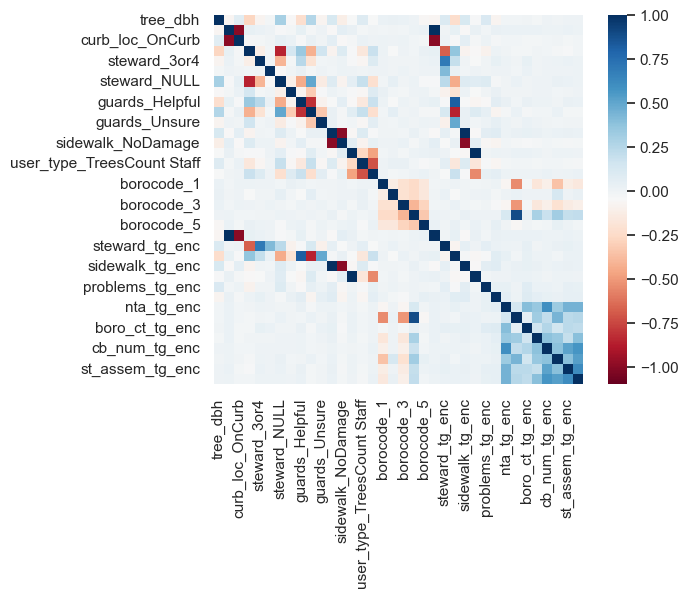

In [163]:
sns.heatmap(corr, square=True, 
            cmap=colormap, 
            linecolor='white', annot=False,
            vmin=1.0, vmax=-1.0)

# 標準化

In [164]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train_std = pd.DataFrame(std_scaler.transform(X_train), columns=X_train.columns)
X_train_std.describe()

,tree_dbh,curb_loc_OffsetFromCurb,curb_loc_OnCurb,steward_1or2,steward_3or4,steward_4orMore,steward_NULL,guards_Harmful,guards_Helpful,guards_NULL,...,problems_tg_enc,spc_common_tg_enc,nta_tg_enc,borocode_tg_enc,boro_ct_tg_enc,zip_city_tg_enc,cb_num_tg_enc,st_senate_tg_enc,st_assem_tg_enc,cncldist_tg_enc
count,19984.00,19984.00,19984.00,19984.00,19984.00,19984.00,19984.00,19984.00,19984.00,19984.00,...,19984.00,19984.00,19984.00,19984.00,19984.00,19984.00,19984.00,19984.00,19984.00,19984.00
mean,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,...,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.30,-0.25,-3.94,-0.50,-0.24,-0.03,-1.71,-0.18,-0.47,-1.72,...,-4.66,-3.86,-4.40,-1.53,-1.76,-4.46,-2.92,-2.73,-4.33,-3.14
25%,-0.82,-0.25,0.25,-0.50,-0.24,-0.03,-1.71,-0.18,-0.47,-1.72,...,-0.27,-0.66,-0.59,-0.88,-0.57,-0.29,-0.55,-0.56,-0.60,-0.50
50%,-0.33,-0.25,0.25,-0.50,-0.24,-0.03,0.59,-0.18,-0.47,0.58,...,-0.27,0.01,-0.03,-0.13,-0.04,-0.12,-0.08,0.02,-0.05,-0.07
75%,0.65,-0.25,0.25,-0.50,-0.24,-0.03,0.59,-0.18,-0.47,0.58,...,0.04,0.41,0.65,1.27,0.43,0.02,0.82,0.62,0.68,0.83
max,3.70,3.94,0.25,2.00,4.19,29.46,0.59,5.44,2.12,0.58,...,17.85,11.78,31.25,1.27,12.51,3.72,24.69,3.51,3.07,2.37


# 特徴量選択
学習に使う特徴量を半分に絞る


In [165]:

from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor

# estimatorとしてGBDTを使用。特徴量を20個選択
selector = RFE(GradientBoostingRegressor(n_estimators=100, random_state=10), n_features_to_select=30)
selector.fit(X_train_std, y_train)
mask = selector.get_support()
#print(X.feature_names)
print(mask)

# 選択した特徴量の列のみ取得
X_selected = selector.transform(X_train_std)
print("X.shape={}, X_selected.shape={}".format(X_train_std.shape, X_selected.shape))

list = []
not_selected = []
columns = X_train_std.columns

for i in range(0, len(mask)):
    
    value = mask[i]
    
    if (value == True):
        list.append(columns[i])
    else:
        not_selected.append(columns[i])

print("選択された25の特徴量：")
print(list)

print("選択されなかった特徴量：")
print(not_selected)

[ True False  True  True False  True  True False  True  True  True  True
  True  True  True  True  True  True  True False False  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True]
X.shape=(19984, 36), X_selected.shape=(19984, 30)
選択された25の特徴量：
['tree_dbh', 'curb_loc_OnCurb', 'steward_1or2', 'steward_4orMore', 'steward_NULL', 'guards_Helpful', 'guards_NULL', 'guards_Unsure', 'sidewalk_Damage', 'sidewalk_NoDamage', 'user_type_NYC Parks Staff', 'user_type_TreesCount Staff', 'user_type_Volunteer', 'borocode_1', 'borocode_2', 'borocode_3', 'curb_loc_tg_enc', 'steward_tg_enc', 'guards_tg_enc', 'sidewalk_tg_enc', 'user_type_tg_enc', 'problems_tg_enc', 'spc_common_tg_enc', 'nta_tg_enc', 'boro_ct_tg_enc', 'zip_city_tg_enc', 'cb_num_tg_enc', 'st_senate_tg_enc', 'st_assem_tg_enc', 'cncldist_tg_enc']
選択されなかった特徴量：
['curb_loc_OffsetFromCurb', 'steward_3or4', 'guards_Harmful', 'borocode_4', 'borocode_5', 'borocode_tg_enc']


# 25に絞ったX_train_stdの変数を次元圧縮

In [166]:
"""
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.manifold import TSNE

pca = decomposition.PCA()
X_pca = pca.fit_transform(X_train_std)
X_pca.shape

X_tsne_nc = TSNE(learning_rate = 100).fit_transform(X_train_std)
print(X_tsne_nc[:5, :5])
print("--- X_tsne_nopca ---")

X_tsne = TSNE(learning_rate = 100).fit_transform(X_pca)
print(X_tsne[:5, :5])
print("--- X_tsne ---")

plt.figure(figsize = (12, 12))

plt.subplot(221)
plt.scatter(X_train_std["tree_dbh"], X_train_std["problems_tg_enc"],color = "blue", alpha = 0.25)

plt.subplot(222)
plt.scatter(X_tsne_nc[:,0], X_tsne_nc[:,1],color = "blue", alpha = 0.25)

plt.subplot(223)
plt.scatter(X_pca[:,0], X_pca[:,1],color = "blue", alpha = 0.25)

plt.subplot(224)
plt.scatter(X_tsne[:,0], X_tsne[:,1],color = "blue", alpha = 0.25)

plt.show()
"""

'\nfrom sklearn import preprocessing\nfrom sklearn import decomposition\nfrom sklearn.manifold import TSNE\n\npca = decomposition.PCA()\nX_pca = pca.fit_transform(X_train_std)\nX_pca.shape\n\nX_tsne_nc = TSNE(learning_rate = 100).fit_transform(X_train_std)\nprint(X_tsne_nc[:5, :5])\nprint("--- X_tsne_nopca ---")\n\nX_tsne = TSNE(learning_rate = 100).fit_transform(X_pca)\nprint(X_tsne[:5, :5])\nprint("--- X_tsne ---")\n\nplt.figure(figsize = (12, 12))\n\nplt.subplot(221)\nplt.scatter(X_train_std["tree_dbh"], X_train_std["problems_tg_enc"],color = "blue", alpha = 0.25)\n\nplt.subplot(222)\nplt.scatter(X_tsne_nc[:,0], X_tsne_nc[:,1],color = "blue", alpha = 0.25)\n\nplt.subplot(223)\nplt.scatter(X_pca[:,0], X_pca[:,1],color = "blue", alpha = 0.25)\n\nplt.subplot(224)\nplt.scatter(X_tsne[:,0], X_tsne[:,1],color = "blue", alpha = 0.25)\n\nplt.show()\n'

In [167]:
"""
plt.figure(figsize = (12, 12))

plt.subplot(221)
plt.scatter(X_train_std["tree_dbh"], X_train_std["problems_tg_enc"],color = "blue", alpha = 0.25)

plt.subplot(222)
plt.scatter(X_tsne_nc[:,0], X_tsne_nc[:,1],color = "blue", alpha = 0.25)

plt.subplot(223)
plt.scatter(X_pca[:,0], X_pca[:,1],c = y_train["health"], alpha = 0.25,cmap='plasma')

plt.subplot(224)
plt.scatter(X_tsne[:,0], X_tsne[:,1],c = y_train["health"], alpha = 0.25,cmap='plasma')
"""

'\nplt.figure(figsize = (12, 12))\n\nplt.subplot(221)\nplt.scatter(X_train_std["tree_dbh"], X_train_std["problems_tg_enc"],color = "blue", alpha = 0.25)\n\nplt.subplot(222)\nplt.scatter(X_tsne_nc[:,0], X_tsne_nc[:,1],color = "blue", alpha = 0.25)\n\nplt.subplot(223)\nplt.scatter(X_pca[:,0], X_pca[:,1],c = y_train["health"], alpha = 0.25,cmap=\'plasma\')\n\nplt.subplot(224)\nplt.scatter(X_tsne[:,0], X_tsne[:,1],c = y_train["health"], alpha = 0.25,cmap=\'plasma\')\n'

In [168]:
# ホールドアウト検証 - 学習用・テスト用の分割を1通り決める
X_tr, X_va, y_tr, y_va = train_test_split(X_train_std[list], y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)

print("学習用・訓練用データの形状：")
print(X_tr.shape)
print(y_tr.shape)
print(X_va.shape)
print(y_va.shape)

学習用・訓練用データの形状：
(15987, 30)
(15987, 1)
(3997, 30)
(3997, 1)


In [169]:
"""
# ホールドアウト検証(次元圧縮した🅂データ)
X_tr_dr, X_va_dr, y_tr_dr, y_va_dr = train_test_split(X_tsne, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)

print("学習用・訓練用データの形状：")
print(X_tr.shape)
print(y_tr.shape)
print(X_va.shape)
print(y_va.shape)
"""

'\n# ホールドアウト検証(次元圧縮した🅂データ)\nX_tr_dr, X_va_dr, y_tr_dr, y_va_dr = train_test_split(X_tsne, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)\n\nprint("学習用・訓練用データの形状：")\nprint(X_tr.shape)\nprint(y_tr.shape)\nprint(X_va.shape)\nprint(y_va.shape)\n'

# モデル最適化

In [170]:
"""
import optuna

# LGBMのパラメータ
params_base = {"boosting_type":"gbdt",
          "objective":"multiclass",
          "metric":"multi_logloss",
          "num_class":"3",
          "learning_rate":0.01,
          "n_estimators":1000,
          "random_state":123,
          "importance_type":"gain",
          "early_stopping_round":100,
          "verbose":10
          }

def objective(trial):
    from sklearn.metrics import f1_score

# チューニングで探索する最適パラメータ
    params_tuning = {
        "num_leaves": trial.suggest_int("num_leaves", 8, 256),
        "min_data_in_leaf":trial.suggest_int("min_data_in_leaf", 5,200),
        "min_sum_hessian_in_leaf":trial.suggest_float("min_sum_hessian_in_leaf", 0.00001, 0.01, log = True),
        "feature_fraction":trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction":trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "lambda_l1":trial.suggest_float("lambda_l1", 0.01, 10.0, log = True),
        "lambda_l2":trial.suggest_float("lambda_l2", 0.01, 10.0, log = True)
    }
    
    #tuningにbaseの値を加える
    params_tuning.update(params_base)
    
    #モデル学習(ベイズ最適化)
    list_metrics=[]
    
    # ホールドアウト検証 - 学習用・テスト用の分割を1通り決める
    X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)

        
    model = lgb.LGBMClassifier(**params_tuning)
        
    model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_va, y_va)], 
                    #early_stopping_rounds=100, 
                    #verbose=0
                    )
    y_va_pred = model.predict(X_va)
    
    #検証精度を求める
    metric_va = f1_score(y_va, y_va_pred, average='macro')
    #metric_va = accuracy_score(y_va, y_va_pred)
    return metric_va

# 探索を実行
sampler = optuna.samplers.TPESampler(seed=123)
study = optuna.create_study(sampler=sampler, direction="maximize")
study.optimize(objective, n_trials=100)
"""

'\nimport optuna\n\n# LGBMのパラメータ\nparams_base = {"boosting_type":"gbdt",\n          "objective":"multiclass",\n          "metric":"multi_logloss",\n          "num_class":"3",\n          "learning_rate":0.01,\n          "n_estimators":1000,\n          "random_state":123,\n          "importance_type":"gain",\n          "early_stopping_round":100,\n          "verbose":10\n          }\n\ndef objective(trial):\n    from sklearn.metrics import f1_score\n\n# チューニングで探索する最適パラメータ\n    params_tuning = {\n        "num_leaves": trial.suggest_int("num_leaves", 8, 256),\n        "min_data_in_leaf":trial.suggest_int("min_data_in_leaf", 5,200),\n        "min_sum_hessian_in_leaf":trial.suggest_float("min_sum_hessian_in_leaf", 0.00001, 0.01, log = True),\n        "feature_fraction":trial.suggest_float("feature_fraction", 0.5, 1.0),\n        "bagging_fraction":trial.suggest_float("bagging_fraction", 0.5, 1.0),\n        "lambda_l1":trial.suggest_float("lambda_l1", 0.01, 10.0, log = True),\n        "lambda_

In [171]:
# 探索で得られた結果を確認
"""
trial = study.best_trial
print("最も高いF1スコア")
print(trial.value)

print("最も高い精度となるパラメータ：")
print(trial.params)
"""

'\ntrial = study.best_trial\nprint("最も高いF1スコア")\nprint(trial.value)\n\nprint("最も高い精度となるパラメータ：")\nprint(trial.params)\n'

最も高い精度：
0.7880910683012259
最も高い精度となるパラメータ：
{'num_leaves': 181, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 4.792414358623587e-05, 'feature_fraction': 0.7756573845414456, 'bagging_fraction': 0.8597344848927815, 'lambda_l1': 0.18591711878786357, 'lambda_l2': 8.755734725056497}

In [172]:
"""
params_best = trial.params
params_best.update(params_base)
display(params_best)
"""

'\nparams_best = trial.params\nparams_best.update(params_base)\ndisplay(params_best)\n'

In [173]:
# LGBMのモデル
"""
model = lgb.LGBMClassifier(**params_best)
model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_va, y_va)])
"""

'\nmodel = lgb.LGBMClassifier(**params_best)\nmodel.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_va, y_va)])\n'

In [174]:
# AUC値に加え精度を算出する
"""
y_tr_pred = model.predict(X_tr)
y_va_pred = model.predict(X_va)

metric_tr = accuracy_score(y_tr, y_tr_pred)
metric_va = accuracy_score(y_va, y_va_pred)
print("モデル精度:")
print("学習精度")
print(metric_tr)
print("検証精度")
print(metric_va)
"""


'\ny_tr_pred = model.predict(X_tr)\ny_va_pred = model.predict(X_va)\n\nmetric_tr = accuracy_score(y_tr, y_tr_pred)\nmetric_va = accuracy_score(y_va, y_va_pred)\nprint("モデル精度:")\nprint("学習精度")\nprint(metric_tr)\nprint("検証精度")\nprint(metric_va)\n'

In [175]:
"""
from sklearn.metrics import f1_score

valid_predictions = model.predict(X_va)
valid_f1 = f1_score(y_va, valid_predictions, average='macro')

print("マクロf1スコア：")
print(valid_f1)

micro_f1 = f1_score(y_va, valid_predictions, average='micro')

print("ミクロf1スコア：")
print(micro_f1)

from sklearn.metrics import balanced_accuracy_score
bas_score = balanced_accuracy_score(y_va, valid_predictions)

print("比重付き精度：")
print(bas_score)

# 混合行列 - ラベルの正誤の分類数をまとめる
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_va_pred, y_va)
print("混合行列：")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1","2"])
disp.plot()
plt.show()
"""



'\nfrom sklearn.metrics import f1_score\n\nvalid_predictions = model.predict(X_va)\nvalid_f1 = f1_score(y_va, valid_predictions, average=\'macro\')\n\nprint("マクロf1スコア：")\nprint(valid_f1)\n\nmicro_f1 = f1_score(y_va, valid_predictions, average=\'micro\')\n\nprint("ミクロf1スコア：")\nprint(micro_f1)\n\nfrom sklearn.metrics import balanced_accuracy_score\nbas_score = balanced_accuracy_score(y_va, valid_predictions)\n\nprint("比重付き精度：")\nprint(bas_score)\n\n# 混合行列 - ラベルの正誤の分類数をまとめる\nfrom sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay\n\ncm = confusion_matrix(y_va_pred, y_va)\nprint("混合行列：")\nprint(cm)\n\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1","2"])\ndisp.plot()\nplt.show()\n'

→ようやく改善が見られた。1, 2のラベルが正確に分類されるようにする。

In [176]:
# 寄与率算出
"""
# feature importanceを表示
# importanceを表示する
importance = pd.DataFrame(model.feature_importances_, index=X_tr.columns, columns=['importance'])
impo02 = importance.sort_values(by="importance")
display(impo02)
"""

'\n# feature importanceを表示\n# importanceを表示する\nimportance = pd.DataFrame(model.feature_importances_, index=X_tr.columns, columns=[\'importance\'])\nimpo02 = importance.sort_values(by="importance")\ndisplay(impo02)\n'

In [177]:
"""
lgb.plot_importance(model)
"""

'\nlgb.plot_importance(model)\n'

problems_TrunkOther	0.000000
problems_StonesTrunkOther	2.406300
problems_BranchOther	10.268320
steward_3or4	13.906020
problems_RootOtherTrunkOtherBranchOther	20.130170
steward_4orMore	22.130930
curb_loc_OnCurb	26.089900
problems_StonesRootOther	29.473130
steward_NULL	31.843760
sidewalk_NoDamage	37.184240
problems_StonesBranchOther	38.574340
curb_loc_OffsetFromCurb	38.776410
problems_BranchLights	39.326430
guards_Unsure	40.097710
problems_RootOther	49.345920
guards_Harmful	54.356240

problemsは殆ど寄与していないものもある
problems_TrunkOther	0.000000
problems_StonesTrunkOther	2.406300
problems_BranchOther	10.268320
problems_RootOtherTrunkOtherBranchOther	20.130170
problems_StonesRootOther	29.473130


In [178]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

reg = LazyClassifier(ignore_warnings=True, random_state=1121, verbose=False,predictions=True)
models, predictions = reg.fit(X_tr, X_va, y_tr, y_va) 

print("モデルの精度・評価指標：")
display(models)
print("テストデータの予測値：")
display(predictions)

 97%|█████████▋| 28/29 [02:12<00:03,  3.78s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 15987, number of used features: 29
[LightGBM] [Info] Start training from score -0.238000
[LightGBM] [Info] Start training from score -1.732206
[LightGBM] [Info] Start training from score -3.355172


100%|██████████| 29/29 [02:13<00:00,  4.59s/it]

モデルの精度・評価指標：


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.55,0.48,None,0.61,0.05
QuadraticDiscriminantAnalysis,0.55,0.40,None,0.59,0.07
Perceptron,0.74,0.39,None,0.71,0.07
GaussianNB,0.72,0.39,None,0.69,0.06
LinearDiscriminantAnalysis,0.79,0.38,None,0.70,0.22
LabelSpreading,0.68,0.37,None,0.68,35.00
PassiveAggressiveClassifier,0.73,0.37,None,0.70,0.09
LabelPropagation,0.67,0.37,None,0.67,31.29
DecisionTreeClassifier,0.65,0.37,None,0.66,0.16


テストデータの予測値：


,AdaBoostClassifier,BaggingClassifier,BernoulliNB,CalibratedClassifierCV,DecisionTreeClassifier,DummyClassifier,ExtraTreeClassifier,ExtraTreesClassifier,GaussianNB,KNeighborsClassifier,...,PassiveAggressiveClassifier,Perceptron,QuadraticDiscriminantAnalysis,RandomForestClassifier,RidgeClassifier,RidgeClassifierCV,SGDClassifier,SVC,XGBClassifier,LGBMClassifier
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,2,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,1,0,0,0,...,0,0,2,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3994,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3995,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


# 近傍中心法による予測 


In [179]:
# 近傍中心法で学習
from sklearn.neighbors import NearestCentroid


model_nc = NearestCentroid()
model_nc.fit(X_tr, y_tr)

y_pred = model_nc.predict(X_va)
y_pred

array([2, 2, 1, ..., 0, 1, 0], dtype=int64)

比重付き精度：
0.47913458012467913
マクロf1スコア：
0.3710747032401896
混合行列：
[[1900  279   37]
 [ 698  206   27]
 [ 552  222   76]]


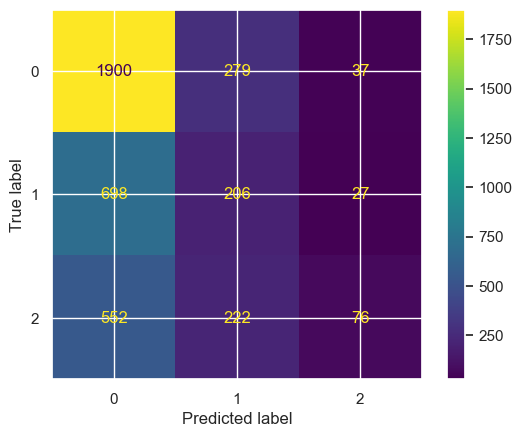

In [180]:
from sklearn.metrics import balanced_accuracy_score
bas_score = balanced_accuracy_score(y_va, y_pred)

print("比重付き精度：")
print(bas_score)

from sklearn.metrics import f1_score

valid_predictions = model_nc.predict(X_va)
valid_f1 = f1_score(y_va, y_pred, average='macro')

print("マクロf1スコア：")
print(valid_f1)

# 混合行列 - ラベルの正誤の分類数をまとめる
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_pred, y_va)
print("混合行列：")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1","2"])
disp.plot()
plt.show()

# ガウシアンナイーブベイズによる予測

In [181]:
from sklearn.naive_bayes import GaussianNB

model_gnb = GaussianNB()
model_gnb.fit(X_tr, y_tr)

y_pred = model_gnb.predict(X_va)
y_pred

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

比重付き精度：
0.39040337367070044
マクロf1スコア：
0.38895594513569476
混合行列：
[[2753  583   95]
 [ 310   94   22]
 [  87   30   23]]


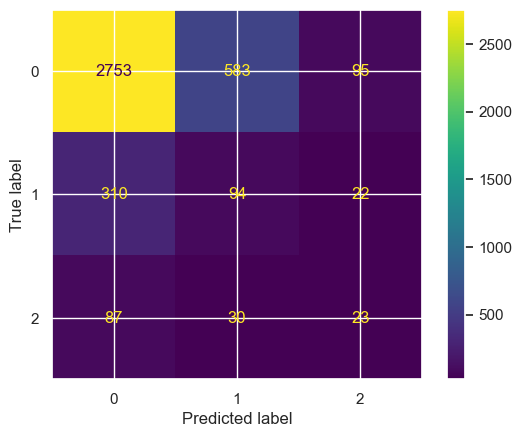

In [182]:
bas_score = balanced_accuracy_score(y_va, y_pred)

print("比重付き精度：")
print(bas_score)

from sklearn.metrics import f1_score

valid_predictions = model_gnb.predict(X_va)
valid_f1 = f1_score(y_va, y_pred, average='macro')

print("マクロf1スコア：")
print(valid_f1)

# 混合行列 - ラベルの正誤の分類数をまとめる
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_pred, y_va)
print("混合行列：")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1","2"])
disp.plot()
plt.show()

# PassiveAggressiveClassifierによる予測

比重付き精度：
0.35991041961338993
マクロf1スコア：
0.371050213509361
混合行列：
[[2619  578  113]
 [ 516  120   16]
 [  15    9   11]]


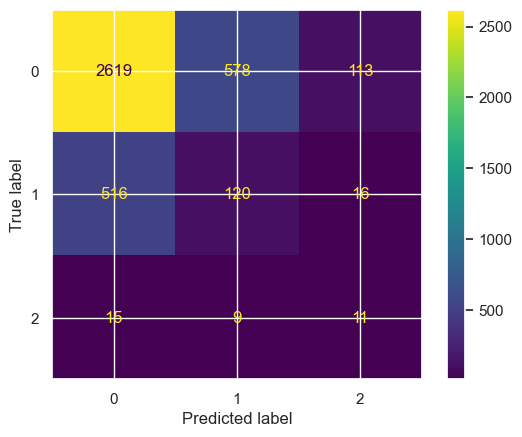

In [183]:
from sklearn.linear_model import PassiveAggressiveClassifier

model_pac = PassiveAggressiveClassifier()
model_pac.fit(X_tr, y_tr)

y_pred = model_pac.predict(X_va)
y_pred

bas_score = balanced_accuracy_score(y_va, y_pred)

print("比重付き精度：")
print(bas_score)

from sklearn.metrics import f1_score

valid_predictions = model_gnb.predict(X_va)
valid_f1 = f1_score(y_va, y_pred, average='macro')

print("マクロf1スコア：")
print(valid_f1)

# 混合行列 - ラベルの正誤の分類数をまとめる
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_pred, y_va)
print("混合行列：")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1","2"])
disp.plot()
plt.show()

# ランダムフォレスト法による予測

In [184]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()
model_rf.fit(X_tr, y_tr)

y_pred = model_rf.predict(X_va)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

比重付き精度：
0.35037927602284036
マクロf1スコア：
0.3376290673465407
混合行列：
[[3052  663  123]
 [  84   43   14]
 [  14    1    3]]


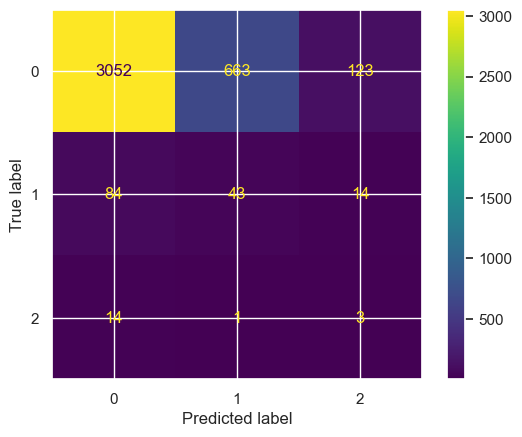

In [185]:
bas_score = balanced_accuracy_score(y_va, y_pred)

print("比重付き精度：")
print(bas_score)

from sklearn.metrics import f1_score

valid_predictions = model_rf.predict(X_va)
valid_f1 = f1_score(y_va, y_pred, average='macro')

print("マクロf1スコア：")
print(valid_f1)

# 混合行列 - ラベルの正誤の分類数をまとめる
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_pred, y_va)
print("混合行列：")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1","2"])
disp.plot()
plt.show()

# ExtraTreeClassifierを学習

In [186]:
from sklearn.tree import ExtraTreeClassifier

model_etc = ExtraTreeClassifier()
model_etc.fit(X_tr, y_tr)

y_pred = model_etc.predict(X_va)
y_pred

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

比重付き精度：
0.35402535491644405
マクロf1スコア：
0.35421719233332766
混合行列：
[[2542  542   98]
 [ 491  145   35]
 [ 117   20    7]]


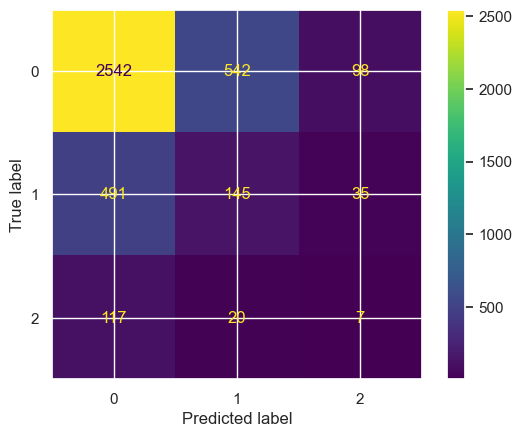

In [187]:
bas_score = balanced_accuracy_score(y_va, y_pred)

print("比重付き精度：")
print(bas_score)

from sklearn.metrics import f1_score
valid_f1 = f1_score(y_va, y_pred, average='macro')

print("マクロf1スコア：")
print(valid_f1)

# 混合行列 - ラベルの正誤の分類数をまとめる
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_pred, y_va)
print("混合行列：")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1","2"])
disp.plot()
plt.show()

# DecisionTreeClassifierを学習

In [188]:
from sklearn.tree import DecisionTreeClassifier

model_dtc = DecisionTreeClassifier()
model_dtc.fit(X_tr, y_tr)

y_pred = model_dtc.predict(X_va)
y_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

比重付き精度：
0.37394520404421394
マクロf1スコア：
0.369384062212258
混合行列：
[[2407  503   96]
 [ 624  162   26]
 [ 119   42   18]]


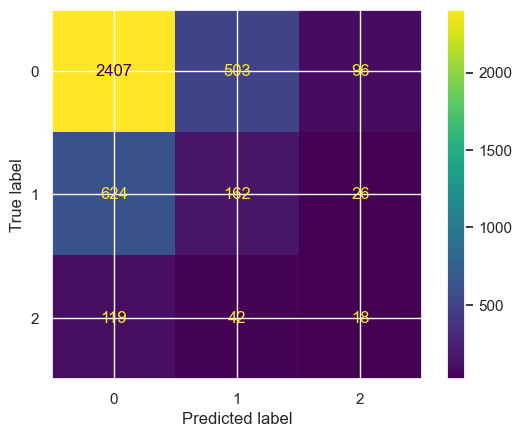

In [189]:
bas_score = balanced_accuracy_score(y_va, y_pred)

print("比重付き精度：")
print(bas_score)

from sklearn.metrics import f1_score
valid_f1 = f1_score(y_va, y_pred, average='macro')

print("マクロf1スコア：")
print(valid_f1)

# 混合行列 - ラベルの正誤の分類数をまとめる
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_pred, y_va)
print("混合行列：")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1","2"])
disp.plot()
plt.show()

# QuadraticDiscriminantAnalysisを学習

In [190]:
#　QuadraticDiscriminantAnalysisを学習
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

model_qda = QuadraticDiscriminantAnalysis()
model_qda.fit(X_tr, y_tr)

y_pred = model_qda.predict(X_va)
y_pred

array([1, 0, 2, ..., 0, 1, 1], dtype=int64)

比重付き精度：
0.362982345853633
マクロf1スコア：
0.3351700635426467
混合行列：
[[1601  343   59]
 [1520  355   70]
 [  29    9   11]]


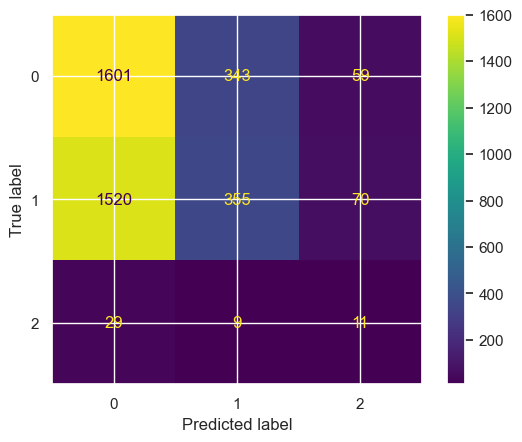

In [191]:
bas_score = balanced_accuracy_score(y_va, y_pred)

print("比重付き精度：")
print(bas_score)

from sklearn.metrics import f1_score
valid_f1 = f1_score(y_va, y_pred, average='macro')

print("マクロf1スコア：")
print(valid_f1)

# 混合行列 - ラベルの正誤の分類数をまとめる
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_pred, y_va)
print("混合行列：")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1","2"])
disp.plot()
plt.show()

# LinearDiscriminantAnalysis

In [192]:
#　QuadraticDiscriminantAnalysisを学習
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model_lda = LinearDiscriminantAnalysis()
model_lda.fit(X_tr, y_tr)

y_pred = model_lda.predict(X_va)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

比重付き精度：
0.37526743150505526
マクロf1スコア：
0.3582076627779813
混合行列：
[[3119  688  119]
 [   2    5    3]
 [  29   14   18]]


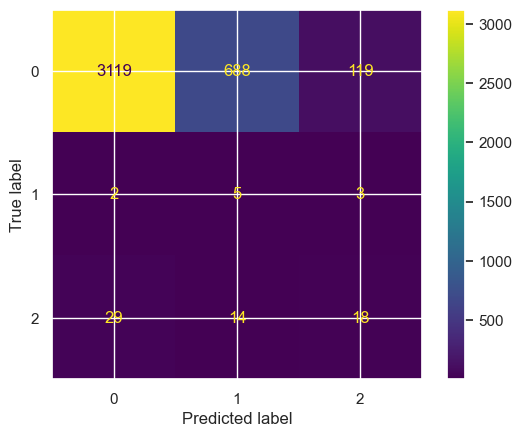

In [193]:
bas_score = balanced_accuracy_score(y_va, y_pred)

print("比重付き精度：")
print(bas_score)

from sklearn.metrics import f1_score
valid_f1 = f1_score(y_va, y_pred, average='macro')

print("マクロf1スコア：")
print(valid_f1)

# 混合行列 - ラベルの正誤の分類数をまとめる
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_pred, y_va)
print("混合行列：")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1","2"])
disp.plot()
plt.show()

# BaggingClassifierを学習

In [194]:
#　QuadraticDiscriminantAnalysisを学習
from sklearn.ensemble import BaggingClassifier

model_bc = BaggingClassifier()
model_bc.fit(X_tr, y_tr)

y_pred = model_bc.predict(X_va)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

比重付き精度：
0.35502226413117505
マクロf1スコア：
0.3515834157277036
混合行列：
[[2966  645  118]
 [ 169   57   16]
 [  15    5    6]]


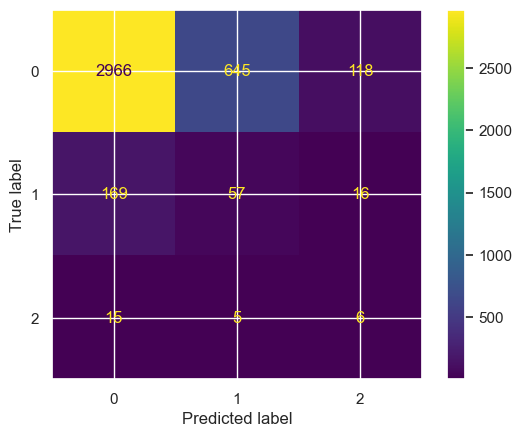

In [195]:
bas_score = balanced_accuracy_score(y_va, y_pred)

print("比重付き精度：")
print(bas_score)

from sklearn.metrics import f1_score
valid_f1 = f1_score(y_va, y_pred, average='macro')

print("マクロf1スコア：")
print(valid_f1)

# 混合行列 - ラベルの正誤の分類数をまとめる
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_pred, y_va)
print("混合行列：")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1","2"])
disp.plot()
plt.show()

In [196]:
# Perceptronを学習

In [197]:
from sklearn.linear_model import Perceptron

model_pcpt = BaggingClassifier()
model_pcpt.fit(X_tr, y_tr)

y_pred = model_pcpt.predict(X_va)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

比重付き精度：
0.361978102572162
マクロf1スコア：
0.3623247159080097
混合行列：
[[2960  637  113]
 [ 173   63   19]
 [  17    7    8]]


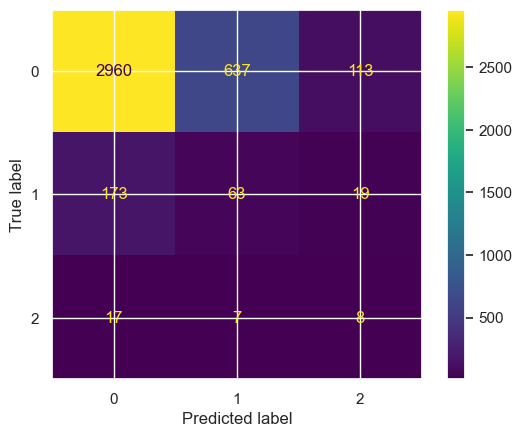

In [198]:
bas_score = balanced_accuracy_score(y_va, y_pred)

print("比重付き精度：")
print(bas_score)

from sklearn.metrics import f1_score
valid_f1 = f1_score(y_va, y_pred, average='macro')

print("マクロf1スコア：")
print(valid_f1)

# 混合行列 - ラベルの正誤の分類数をまとめる
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_pred, y_va)
print("混合行列：")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1","2"])
disp.plot()
plt.show()

In [199]:
from sklearn.ensemble import ExtraTreesClassifier

model_etc = ExtraTreesClassifier()
model_etc.fit(X_tr, y_tr)

y_pred = model_etc.predict(X_va)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

比重付き精度：
0.35007229294358005
マクロf1スコア：
0.3456040744323081
混合行列：
[[2919  652  119]
 [ 197   52   14]
 [  34    3    7]]


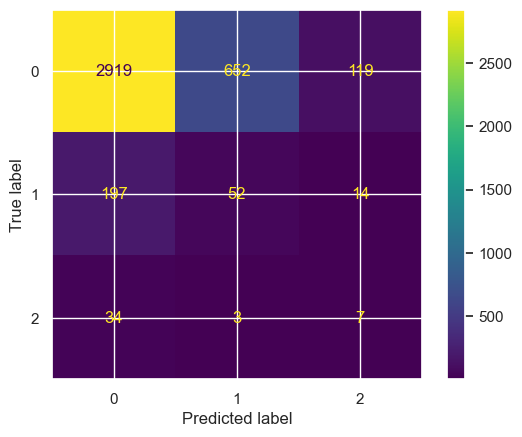

In [200]:
bas_score = balanced_accuracy_score(y_va, y_pred)

print("比重付き精度：")
print(bas_score)

from sklearn.metrics import f1_score
valid_f1 = f1_score(y_va, y_pred, average='macro')

print("マクロf1スコア：")
print(valid_f1)

# 混合行列 - ラベルの正誤の分類数をまとめる
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_pred, y_va)
print("混合行列：")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1","2"])
disp.plot()
plt.show()

# 投稿用データを作成

In [201]:
# 説明変数・目的変数
X_test = test[x_list]
X_test

# 欠損値補完
test.fillna('NULL', inplace=True)
X_test.fillna('NULL', inplace=True)
X_test

,tree_dbh,curb_loc,steward,guards,sidewalk,user_type,problems,spc_common,nta,borocode,boro_ct,zip_city,cb_num,st_senate,st_assem,cncldist
19984,15,OnCurb,NULL,NULL,Damage,NYC Parks Staff,NULL,Callery pear,BK17,3,3062000,Brooklyn,315,22,45,48
19985,5,OnCurb,1or2,NULL,NoDamage,Volunteer,NULL,cherry,BX62,2,2045101,Bronx,212,34,81,11
19986,4,OnCurb,NULL,Unsure,NoDamage,Volunteer,NULL,littleleaf linden,QN60,4,4013800,Kew Gardens,409,14,27,29
19987,7,OnCurb,NULL,NULL,NoDamage,TreesCount Staff,NULL,dawn redwood,BK09,3,3000301,Brooklyn,302,26,52,33
19988,6,OnCurb,1or2,Helpful,NoDamage,TreesCount Staff,Stones,purple-leaf plum,BK75,3,3025100,Brooklyn,303,25,56,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39964,3,OnCurb,1or2,Harmful,Damage,Volunteer,StonesRootOther,Japanese snowbell,SI45,5,5012200,Staten Island,502,24,64,50
39965,9,OnCurb,1or2,NULL,NoDamage,NYC Parks Staff,NULL,silver maple,QN23,4,4093900,College Point,407,11,27,19
39966,16,OnCurb,NULL,NULL,Damage,Volunteer,NULL,Callery pear,BX01,2,2039500,Bronx,206,33,86,15
39967,24,OnCurb,NULL,NULL,Damage,TreesCount Staff,RootOtherTrunkOtherBranchOther,London planetree,BK79,3,3037300,Brooklyn,316,25,55,41


In [202]:
X_test = pd.get_dummies(X_test, columns = dummy_list, drop_first=False)
X_test

,tree_dbh,problems,spc_common,nta,boro_ct,zip_city,cb_num,st_senate,st_assem,cncldist,...,sidewalk_Damage,sidewalk_NoDamage,user_type_NYC Parks Staff,user_type_TreesCount Staff,user_type_Volunteer,borocode_1,borocode_2,borocode_3,borocode_4,borocode_5
19984,15,NULL,Callery pear,BK17,3062000,Brooklyn,315,22,45,48,...,1,0,1,0,0,0,0,1,0,0
19985,5,NULL,cherry,BX62,2045101,Bronx,212,34,81,11,...,0,1,0,0,1,0,1,0,0,0
19986,4,NULL,littleleaf linden,QN60,4013800,Kew Gardens,409,14,27,29,...,0,1,0,0,1,0,0,0,1,0
19987,7,NULL,dawn redwood,BK09,3000301,Brooklyn,302,26,52,33,...,0,1,0,1,0,0,0,1,0,0
19988,6,Stones,purple-leaf plum,BK75,3025100,Brooklyn,303,25,56,36,...,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39964,3,StonesRootOther,Japanese snowbell,SI45,5012200,Staten Island,502,24,64,50,...,1,0,0,0,1,0,0,0,0,1
39965,9,NULL,silver maple,QN23,4093900,College Point,407,11,27,19,...,0,1,1,0,0,0,0,0,1,0
39966,16,NULL,Callery pear,BX01,2039500,Bronx,206,33,86,15,...,1,0,0,0,1,0,1,0,0,0
39967,24,RootOtherTrunkOtherBranchOther,London planetree,BK79,3037300,Brooklyn,316,25,55,41,...,1,0,0,1,0,0,0,1,0,0


In [203]:
X_test.columns

Index(['tree_dbh', 'problems', 'spc_common', 'nta', 'boro_ct', 'zip_city',
       'cb_num', 'st_senate', 'st_assem', 'cncldist',
       'curb_loc_OffsetFromCurb', 'curb_loc_OnCurb', 'steward_1or2',
       'steward_3or4', 'steward_4orMore', 'steward_NULL', 'guards_Harmful',
       'guards_Helpful', 'guards_NULL', 'guards_Unsure', 'sidewalk_Damage',
       'sidewalk_NoDamage', 'user_type_NYC Parks Staff',
       'user_type_TreesCount Staff', 'user_type_Volunteer', 'borocode_1',
       'borocode_2', 'borocode_3', 'borocode_4', 'borocode_5'],
      dtype='object')

In [204]:
# 一挙にターゲットエンコーディング
for col in cols:
    column_means = train.groupby(col)["health"].mean("health")
    column_means
    
    colname = col + "_tg_enc"
    
    X_test[colname] = test[col].map(column_means)

In [205]:
# problems, spc_commonをドロップアウト
X_test = X_test.drop(drop_col , axis=1)
X_test

,tree_dbh,curb_loc_OffsetFromCurb,curb_loc_OnCurb,steward_1or2,steward_3or4,steward_4orMore,steward_NULL,guards_Harmful,guards_Helpful,guards_NULL,...,problems_tg_enc,spc_common_tg_enc,nta_tg_enc,borocode_tg_enc,boro_ct_tg_enc,zip_city_tg_enc,cb_num_tg_enc,st_senate_tg_enc,st_assem_tg_enc,cncldist_tg_enc
19984,15,0,1,0,0,0,1,0,0,1,...,0.24,0.26,0.22,0.24,0.32,0.24,0.21,0.25,0.20,0.20
19985,5,0,1,1,0,0,0,0,0,1,...,0.24,0.20,0.34,0.25,0.25,0.25,0.30,0.25,0.26,0.26
19986,4,0,1,0,0,0,1,0,0,0,...,0.24,0.25,0.19,0.26,0.25,0.18,0.21,0.22,0.23,0.24
19987,7,0,1,0,0,0,1,0,0,1,...,0.24,0.25,0.15,0.24,0.06,0.24,0.21,0.21,0.19,0.21
19988,6,0,1,1,0,0,0,0,1,0,...,0.25,0.24,0.22,0.24,0.16,0.24,0.22,0.23,0.21,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39964,3,0,1,1,0,0,0,1,0,0,...,0.31,0.50,0.25,0.25,0.27,0.25,0.26,0.25,0.27,0.26
39965,9,0,1,1,0,0,0,0,0,1,...,0.24,0.23,0.22,0.26,0.33,0.30,0.29,0.27,0.23,0.29
39966,16,0,1,0,0,0,1,0,0,1,...,0.24,0.26,0.23,0.25,0.24,0.25,0.25,0.28,0.22,0.29
39967,24,0,1,0,0,0,1,0,0,1,...,0.21,0.23,0.24,0.24,0.30,0.24,0.26,0.23,0.22,0.20


In [206]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
std_scaler.fit(X_test)
X_test_std = pd.DataFrame(std_scaler.transform(X_test), columns=X_train.columns)
X_test_std
# X_train_std.describe()

,tree_dbh,curb_loc_OffsetFromCurb,curb_loc_OnCurb,steward_1or2,steward_3or4,steward_4orMore,steward_NULL,guards_Harmful,guards_Helpful,guards_NULL,...,problems_tg_enc,spc_common_tg_enc,nta_tg_enc,borocode_tg_enc,boro_ct_tg_enc,zip_city_tg_enc,cb_num_tg_enc,st_senate_tg_enc,st_assem_tg_enc,cncldist_tg_enc
0,0.41,-0.26,0.26,-0.52,-0.23,-0.03,0.60,-0.19,-0.48,0.59,...,-0.26,0.26,-0.43,-0.89,0.62,-0.29,-1.02,0.04,-1.30,-1.48
1,-0.80,-0.26,0.26,1.93,-0.23,-0.03,-1.68,-0.19,-0.48,0.59,...,-0.26,-0.67,1.82,0.04,0.05,0.01,1.47,-0.00,0.46,0.47
2,-0.93,-0.26,0.26,-0.52,-0.23,-0.03,0.60,-0.19,-0.48,-1.68,...,-0.26,-0.01,-1.13,1.25,0.05,-3.01,-1.14,-1.38,-0.42,-0.15
3,-0.56,-0.26,0.26,-0.52,-0.23,-0.03,0.60,-0.19,-0.48,0.59,...,-0.26,-0.01,-1.93,-0.89,-1.50,-0.29,-1.16,-1.54,-1.69,-1.20
4,-0.68,-0.26,0.26,1.93,-0.23,-0.03,-1.68,-0.19,2.07,-1.68,...,0.04,-0.05,-0.58,-0.89,-0.71,-0.29,-0.83,-0.55,-1.08,-0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19697,-1.05,-0.26,0.26,1.93,-0.23,-0.03,-1.68,5.35,-0.48,-1.68,...,1.35,3.85,0.08,-0.14,0.21,-0.04,0.46,0.02,0.81,0.40
19698,-0.32,-0.26,0.26,1.93,-0.23,-0.03,-1.68,-0.19,-0.48,0.59,...,-0.26,-0.35,-0.42,1.25,0.74,2.43,1.37,1.18,-0.42,1.42
19699,0.54,-0.26,0.26,-0.52,-0.23,-0.03,0.60,-0.19,-0.48,0.59,...,-0.26,0.26,-0.29,0.04,-0.07,0.01,0.10,1.36,-0.66,1.56
19700,1.51,-0.26,0.26,-0.52,-0.23,-0.03,0.60,-0.19,-0.48,0.59,...,-0.93,-0.35,-0.21,-0.89,0.47,-0.29,0.37,-0.55,-0.91,-1.57


In [207]:
X_test_std = X_test_std[list]
X_test_std

,tree_dbh,curb_loc_OnCurb,steward_1or2,steward_4orMore,steward_NULL,guards_Helpful,guards_NULL,guards_Unsure,sidewalk_Damage,sidewalk_NoDamage,...,user_type_tg_enc,problems_tg_enc,spc_common_tg_enc,nta_tg_enc,boro_ct_tg_enc,zip_city_tg_enc,cb_num_tg_enc,st_senate_tg_enc,st_assem_tg_enc,cncldist_tg_enc
0,0.41,0.26,-0.52,-0.03,0.60,-0.48,0.59,-0.20,1.07,-1.07,...,2.33,-0.26,0.26,-0.43,0.62,-0.29,-1.02,0.04,-1.30,-1.48
1,-0.80,0.26,1.93,-0.03,-1.68,-0.48,0.59,-0.20,-0.94,0.94,...,-0.50,-0.26,-0.67,1.82,0.05,0.01,1.47,-0.00,0.46,0.47
2,-0.93,0.26,-0.52,-0.03,0.60,-0.48,-1.68,5.02,-0.94,0.94,...,-0.50,-0.26,-0.01,-1.13,0.05,-3.01,-1.14,-1.38,-0.42,-0.15
3,-0.56,0.26,-0.52,-0.03,0.60,-0.48,0.59,-0.20,-0.94,0.94,...,-0.28,-0.26,-0.01,-1.93,-1.50,-0.29,-1.16,-1.54,-1.69,-1.20
4,-0.68,0.26,1.93,-0.03,-1.68,2.07,-1.68,-0.20,-0.94,0.94,...,-0.28,0.04,-0.05,-0.58,-0.71,-0.29,-0.83,-0.55,-1.08,-0.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19697,-1.05,0.26,1.93,-0.03,-1.68,-0.48,-1.68,-0.20,1.07,-1.07,...,-0.50,1.35,3.85,0.08,0.21,-0.04,0.46,0.02,0.81,0.40
19698,-0.32,0.26,1.93,-0.03,-1.68,-0.48,0.59,-0.20,-0.94,0.94,...,2.33,-0.26,-0.35,-0.42,0.74,2.43,1.37,1.18,-0.42,1.42
19699,0.54,0.26,-0.52,-0.03,0.60,-0.48,0.59,-0.20,1.07,-1.07,...,-0.50,-0.26,0.26,-0.29,-0.07,0.01,0.10,1.36,-0.66,1.56
19700,1.51,0.26,-0.52,-0.03,0.60,-0.48,0.59,-0.20,1.07,-1.07,...,-0.28,-0.93,-0.35,-0.21,0.47,-0.29,0.37,-0.55,-0.91,-1.57


In [208]:
# 予測
y_test_pred = model_gnb.predict(X_test_std)
y_test_pred

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [209]:
# NOTE 予測結果を1次元ベクトルにする
y_test_pred = np.squeeze(y_test_pred)
y_test_pred.shape
y_test_pred

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [210]:
# NOTE 予測結果をpdにして処理
df_submit = pd.DataFrame(data=y_test_pred, columns=['y_pred'])
df_submit

,y_pred
0,0
1,0
2,1
3,0
4,0
...,...
19697,1
19698,0
19699,0
19700,0


In [211]:
df_submit.value_counts()

y_pred
0         16675
1          2403
2           624
dtype: int64

In [212]:
df_submit['y_pred'] = df_submit['y_pred'].map({0:1, 1:0, 2:2})
df_submit

,y_pred
0,1
1,1
2,0
3,1
4,1
...,...
19697,0
19698,1
19699,1
19700,1


In [213]:
df_submit.value_counts()

y_pred
1         16675
0          2403
2           624
dtype: int64

In [214]:
y_test_pred = df_submit["y_pred"].to_numpy()

In [215]:
sample_submit[1] = y_test_pred
sample_submit

,1
0,
19984,1
19985,1
19986,0
19987,1
19988,1
...,...
39964,0
39965,1
39966,1


In [216]:
#木の健康状態を0・1を置き換える
#train['health'] = train['health'].map({0:1, 1:0, 2:2})
#train

sample_submit.to_csv('submit_30_GNB_05.csv', header=None)